<a href="https://colab.research.google.com/github/claudio1975/US_Injuries_Flood_Prediction/blob/main/WHOLE_INJURIES/Flood_pred_whole_inj_work_multi_step_aug_v_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Injuries_Direct multi step Flood Prediction with Data Augmentation

### Prepare Workspace

In [ ]:
! pip install shap &> /dev/null

In [ ]:
! pip install optuna &> /dev/null

In [ ]:
! pip install catboost &> /dev/null

In [ ]:
! pip install dask[dataframe] &> /dev/null

In [ ]:
! pip install h2o &> /dev/null

In [ ]:
#setup deterministic results
import numpy as np
from numpy.random import seed
seed=0
np.random.seed(seed)


In [ ]:
# utils packages
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import datetime
import scipy
import scipy.stats as stats
import statsmodels
import sklearn
import lightgbm
import xgboost
import catboost
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import radians, sin, cos, sqrt, atan2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import randint
import optuna


# packages for prediction and other utils functions
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import h2o
from h2o.estimators.gam import H2OGeneralizedAdditiveEstimator

# to evaluate models
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
import shap

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
np.__version__

'1.26.4'

In [ ]:
pd.__version__

'2.1.4'

In [ ]:
matplotlib.__version__

'3.7.1'

In [ ]:
sns.__version__

'0.13.1'

In [ ]:
scipy.__version__

'1.13.1'

In [ ]:
statsmodels.__version__

'0.14.2'

In [ ]:
sklearn.__version__

'1.3.2'

In [ ]:
optuna.__version__

'4.0.0'

In [ ]:
shap.__version__

'0.46.0'

In [ ]:
lightgbm.__version__

'4.4.0'

In [ ]:
xgboost.__version__

'2.1.1'

In [ ]:
catboost.__version__

'1.2.7'

In [ ]:
h2o.__version__

'3.46.0.5'

### Upload data set

In [ ]:
df=pd.read_csv('./flood_dataset_fe4.csv',index_col=0)

### Handling Date Time format

In [ ]:
# Trasform BEGIN_DATE_TIME and END_DATE_TIME in datetime format
df["BEGIN_DATE_TIME"] = pd.to_datetime(df["BEGIN_DATE_TIME"], format="%d-%b-%y %H:%M:%S")
df["END_DATE_TIME"] = pd.to_datetime(df["END_DATE_TIME"], format="%d-%b-%y %H:%M:%S")

In [ ]:
# Create index
df.index = pd.to_datetime(df.BEGIN_DATE_TIME)
df.index.names = ['Date']
# Sort DataFrame by date column in descending order
df.sort_values(by='Date', ascending = True, inplace = True)
# Sanity check: data span.
df.index.min(), df.index.max()

(Timestamp('2006-10-02 14:00:00'), Timestamp('2022-12-31 23:00:00'))

### Have a brief look of the data set

In [ ]:
df.shape

(38398, 53)

In [ ]:
df.columns

Index(['EVENT_ID', 'BEGIN_DATE_TIME', 'END_DATE_TIME', 'STATE', 'STATE_FIPS',
       'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'FLOOD_CAUSE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON',
       'END_LAT', 'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
       'predicted_sentiment_gpt', 'embed_episod_gpt0', 'embed_episod_gpt1',
       'embed_episod_gpt2', 'embed_episod_gpt3', 'embed_episod_gpt4',
       'embed_episod_gpt5', 'embed_episod_gpt6', 'embed_episod_gpt7',
       'embed_episod_gpt8', 'embed_episod_gpt9', 'embed_event_gpt0',
       'embed_event_gpt1', 'embed_event_gpt2', 'embed_event_gpt3',
       'embed_event_gpt4', 'embed_event_gpt5', 'embed_event_gpt6',
       'embed_event_gpt7', 'embed_event_gpt8', 'embed_event_gpt9',
       

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38398 entries, 2006-10-02 14:00:00 to 2022-12-31 23:00:00
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   EVENT_ID                 38398 non-null  int64         
 1   BEGIN_DATE_TIME          38398 non-null  datetime64[ns]
 2   END_DATE_TIME            38398 non-null  datetime64[ns]
 3   STATE                    38398 non-null  object        
 4   STATE_FIPS               38398 non-null  float64       
 5   EVENT_TYPE               38398 non-null  object        
 6   CZ_TYPE                  38398 non-null  object        
 7   CZ_FIPS                  38398 non-null  int64         
 8   CZ_NAME                  38398 non-null  object        
 9   WFO                      38398 non-null  object        
 10  CZ_TIMEZONE              38398 non-null  object        
 11  INJURIES_DIRECT          38398 non-null  int64         
 1

In [ ]:
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
num = df[num_cols]
num.columns

Index(['EVENT_ID', 'STATE_FIPS', 'CZ_FIPS', 'INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'BEGIN_RANGE', 'END_RANGE',
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'embed_episod_gpt0',
       'embed_episod_gpt1', 'embed_episod_gpt2', 'embed_episod_gpt3',
       'embed_episod_gpt4', 'embed_episod_gpt5', 'embed_episod_gpt6',
       'embed_episod_gpt7', 'embed_episod_gpt8', 'embed_episod_gpt9',
       'embed_event_gpt0', 'embed_event_gpt1', 'embed_event_gpt2',
       'embed_event_gpt3', 'embed_event_gpt4', 'embed_event_gpt5',
       'embed_event_gpt6', 'embed_event_gpt7', 'embed_event_gpt8',
       'embed_event_gpt9'],
      dtype='object')

In [ ]:
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
cat = df[obj_cols]
cat.columns

Index(['STATE', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'SOURCE', 'FLOOD_CAUSE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_AZIMUTH', 'END_LOCATION', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
       'predicted_sentiment_gpt', 'predicted_risk_gpt'],
      dtype='object')

### Build features

In [ ]:
# Created year, month, day, time begin/end feature
df_1 = df.copy()
df_1['YEAR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).year
df_1['MONTH_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).month
df_1['DAY_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).day
df_1['HOUR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).hour
df_1['YEAR_BEGIN']= df_1["YEAR_BEGIN"].astype("int64")
df_1['MONTH_BEGIN']= df_1["MONTH_BEGIN"].astype("int64")
df_1['DAY_BEGIN']= df_1["DAY_BEGIN"].astype("int64")
df_1['HOUR_BEGIN']= df_1["HOUR_BEGIN"].astype("int64")
df_1['YEAR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).year
df_1['MONTH_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).month
df_1['DAY_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).day
df_1['HOUR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).hour
df_1['YEAR_END']= df_1["YEAR_END"].astype("int64")
df_1['MONTH_END']= df_1["MONTH_END"].astype("int64")
df_1['DAY_END']= df_1["DAY_END"].astype("int64")
df_1['HOUR_END']= df_1["HOUR_END"].astype("int64")

In [ ]:
# Calculate the difference between dates and convert it to days and hours
df_1['DAY_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.days
df_1['HOUR_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.total_seconds() / 3600

In [ ]:
# Merge Origin and Destination to have a look at the round event
df_1['LOCATION_ORIGIN_DESTINATION'] = df_1['BEGIN_LOCATION']+'-'+df_1['END_LOCATION']
df_1['BEGIN_END_AZIMUTH'] = df_1['BEGIN_AZIMUTH']+'-'+df_1['END_AZIMUTH']

In [ ]:
# new target features
df_1['WHOLE_INJURIES'] = df_1['INJURIES_INDIRECT'] + df_1['INJURIES_DIRECT']
df_1['WHOLE_DEATHS'] = df_1['DEATHS_INDIRECT'] + df_1['DEATHS_DIRECT']
df_1['WHOLE_DAMAGE'] = df_1['DAMAGE_CROPS'] + df_1['DAMAGE_PROPERTY']

In [ ]:
# Distance of the event
def haversine_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = radians(row['BEGIN_LAT']), radians(row['BEGIN_LON'])
    lat2, lon2 = radians(row['END_LAT']), radians(row['END_LON'])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius_of_earth = 6371  # Earth's radius in kilometers
    distance = radius_of_earth * c

    return distance

In [ ]:
# Distance
df_1['DISTANCE'] = df_1.apply(haversine_distance, axis=1)
df_1['DISTANCE_RANGE']=df_1['END_RANGE']-df_1['BEGIN_RANGE']

In [ ]:
# Drop old variables replaced by new variables
df_2=df_1.copy()
df_2 = df_2.drop(['BEGIN_LOCATION','END_LOCATION','BEGIN_AZIMUTH','END_AZIMUTH',
                  'INJURIES_INDIRECT','DEATHS_INDIRECT','DAMAGE_CROPS',
                  'END_RANGE','BEGIN_RANGE','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON'], axis=1)

### Encoding

In [ ]:
df_encod=df_2.copy()

In [ ]:
# Define the function to encode top N and group others
def encode_top_n_and_group_others(df, column, n=10):
    # Calculate the top N classes
    top_n_classes = df[column].value_counts().index[:n]

    # Create a dictionary to map the top N classes to integers
    state_group = {state: i+1 for i, state in enumerate(top_n_classes)}

    # Map the states to their corresponding integer or '0' for others
    df[column] = df[column].map(state_group).fillna(0).astype(int)

    return df, state_group

def create_encoded_table(data, var_c, var_t):
    # Encode the categorical variable and group others
    encoded_data, state_group = encode_top_n_and_group_others(data, var_c)

    # Aggregate the data based on the encoded categories
    agg_data = encoded_data.groupby(var_c)[var_t].sum().reset_index()

    # Sort the aggregated data in decreasing order
    agg_data_sorted = agg_data.sort_values(by=var_t, ascending=False)

    # Create a lookup dictionary for original category labels
    reverse_state_group = {v: k for k, v in state_group.items()}
    reverse_state_group[0] = 'Others'

    # Add the original category labels to the table
    agg_data_sorted['Original Label'] = agg_data_sorted[var_c].map(reverse_state_group)

    return agg_data_sorted




In [ ]:
# encod_predicted_sentiment_gpt
encod_sentiment = {'negative':'0','positive':'1','neutral':'2'}
df_encod['predicted_sentiment_gpt'] = df_encod['predicted_sentiment_gpt'].map(encod_sentiment)
df_encod['predicted_sentiment_gpt']= df_encod['predicted_sentiment_gpt'].astype(int)
# encod_predicted_risk_gpt
encod_risk = {'high risk':'0','medium risk':'1','low risk':'2'}
df_encod['predicted_risk_gpt'] = df_encod['predicted_risk_gpt'].map(encod_risk)
df_encod['predicted_risk_gpt']= df_encod['predicted_risk_gpt'].astype(int)


In [ ]:
# grouping_STATE
result_table = create_encoded_table(df_encod, var_c='STATE', var_t='INJURIES_DIRECT')

# Display the table
result_table

STATE  INJURIES_DIRECT Original Label
0       0               35         Others
5       5               24     CALIFORNIA
8       8               11       ILLINOIS
7       7               10        INDIANA
3       3                8       KENTUCKY
10     10                8       ARKANSAS
2       2                5       MISSOURI
4       4                3           IOWA
6       6                2           OHIO
1       1                1       VIRGINIA
9       9                0   SOUTH DAKOTA

In [ ]:
# grouping_CZ_NAME
result_table = create_encoded_table(df_encod, var_c='CZ_NAME', var_t='WHOLE_INJURIES')

# Display the table
result_table

CZ_NAME  WHOLE_INJURIES Original Label
0         0             147         Others
3         3               7        JACKSON
8         8               3       FRANKLIN
1         1               1     WASHINGTON
2         2               0     MONTGOMERY
5         5               0       WOODRUFF
4         4               0          UNION
6         6               0      JEFFERSON
7         7               0      FREDERICK
9         9               0         GREENE
10       10               0           CLAY

In [ ]:
# grouping_WFO
result_table = create_encoded_table(df_encod, var_c='WFO', var_t='WHOLE_INJURIES')

# Display the table
result_table

WFO  WHOLE_INJURIES Original Label
0     0              98         Others
9     9              22            BOX
2     2              17            PAH
7     7               8            PHI
6     6               8            LZK
8     8               3            ARX
5     5               2            ILN
1     1               0            LWX
4     4               0            SGF
3     3               0            FSD
10   10               0            RLX

In [ ]:
# grouping_CZ_TIMEZONE
result_table = create_encoded_table(df_encod, var_c='CZ_TIMEZONE', var_t='WHOLE_INJURIES')

# Display the table
result_table

CZ_TIMEZONE  WHOLE_INJURIES Original Label
1            2              68          CST-6
0            1              57          EST-5
2            3              28          PST-8
3            4               5          MST-7
4            5               0          AST-4
5            6               0         AKST-9
6            7               0          GST10
7            8               0         HST-10

In [ ]:
# grouping_SOURCE
result_table = create_encoded_table(df_encod, var_c='SOURCE', var_t='WHOLE_INJURIES')

# Display the table
result_table

SOURCE  WHOLE_INJURIES             Original Label
0        0              67                     Others
3        3              32            Law Enforcement
9        9              19            Broadcast Media
2        2              16          Emergency Manager
10      10               9       Other Federal Agency
6        6               8            Trained Spotter
1        1               5          River/Stream Gage
8        8               1                     Public
5        5               1  Official NWS Observations
4        4               0     Department of Highways
7        7               0            911 Call Center

In [ ]:
# grouping_FLOOD_CAUSE
result_table = create_encoded_table(df_encod, var_c='FLOOD_CAUSE', var_t='WHOLE_INJURIES')

# Display the table
result_table

FLOOD_CAUSE  WHOLE_INJURIES                Original Label
0            1             135                    Heavy Rain
1            2              21        Heavy Rain / Snow Melt
2            3               1  Heavy Rain / Tropical System
3            4               1                       Ice Jam
4            5               0           Planned Dam Release
5            6               0             Dam / Levee Break
6            7               0        Heavy Rain / Burn Area

In [ ]:
# grouping_BEGIN_END_AZIMUTH
result_table = create_encoded_table(df_encod, var_c='BEGIN_END_AZIMUTH', var_t='WHOLE_INJURIES')

# Display the table
result_table

BEGIN_END_AZIMUTH  WHOLE_INJURIES Original Label
0                   0             124         Others
1                   1              15            N-N
4                   4               7            S-S
2                   2               3            W-W
9                   9               3        ENE-ENE
5                   5               2          NW-NW
3                   3               2            E-E
6                   6               1        NNW-NNW
10                 10               1          SW-SW
8                   8               0        WNW-WNW
7                   7               0          NE-NE

In [ ]:
# grouping_LOCATION_ORIGIN_DESTINATION
result_table = create_encoded_table(df_encod, var_c='LOCATION_ORIGIN_DESTINATION', var_t='WHOLE_INJURIES')

# Display the table
result_table

LOCATION_ORIGIN_DESTINATION  WHOLE_INJURIES           Original Label
0                             0             158                   Others
1                             1               0        SAN JUAN-SAN JUAN
2                             2               0         RIVERSIDE-CAVELL
3                             3               0         AUGUSTA-RUFFWOOD
4                             4               0  SHAWNEETOWN-SHAWNEETOWN
5                             5               0    PETERSBURG-PETERSBURG
6                             6               0          AUGUSTA-AUGUSTA
7                             7               0        PARADISE-PARADISE
8                             8               0            BOSTON-BOSTON
9                             9               0      MT VERNON-MT VERNON
10                           10               0        FAIRVIEW-FAIRVIEW

### Remove Outliers

In [ ]:
df_3=df_encod.copy()

#### Fine-Tuning Isolation Forest

In [ ]:
# Create a custom scorer object
#poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

#param_grid = {
#    "contamination": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
#}

#iso_forest = IsolationForest(random_state=0)
#iso_forest_model = GridSearchCV(iso_forest, param_grid, cv=5, scoring=poisson_scorer)
#iso_forest_model.fit(df_3[['INJURIES_DIRECT','DEATHS_DIRECT','DAMAGE_PROPERTY',
#                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE']])

#print("Best parameters:", iso_forest_model.best_params_)

#### Fit the model

In [ ]:
def is_outlier(x):
    return 'yes' if x == -1 else 'no'

model = IsolationForest(contamination=0.01, random_state=0)
predictions = model.fit_predict(df_3[['INJURIES_DIRECT','DEATHS_DIRECT','DAMAGE_PROPERTY',
                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE']])
outliers = np.vectorize(is_outlier)(predictions)
outliers_series = pd.DataFrame(outliers, columns=['outliers'], index=df_3.index)
df_3_ = pd.concat([df_3, outliers_series], axis=1)

In [ ]:
df_3_.query('outliers=="yes"').shape

(384, 58)

In [ ]:
df_4 = df_3_.query('outliers=="no"')
df_4.shape

(38014, 58)

In [ ]:
# drop not useful features and targets not used
df_5=df_4.drop(['EVENT_ID','BEGIN_DATE_TIME','END_DATE_TIME','EPISODE_NARRATIVE',
                     'EVENT_NARRATIVE','EVENT_TYPE','CZ_TYPE','outliers','DEATHS_DIRECT','DAMAGE_PROPERTY',
                     'INJURIES_DIRECT','WHOLE_DEATHS','WHOLE_DAMAGE'], axis=1)


In [ ]:
target = df_5[['WHOLE_INJURIES']]
X_all = df_5.drop(['WHOLE_INJURIES'], axis=1)
X_all.shape

(38014, 44)

### Zero Variance Predictors

In [ ]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) ==0]
to_drop

[]

In [ ]:
# Drop features
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Normality Test

In [ ]:
# normality test
stat, p = shapiro(X_all_v)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)')
else:
  print('Sample does not look Gaussian (reject H0)')

Statistics=0.230, p=0.000
Sample does not look Gaussian (reject H0)


### Correlated Predictors

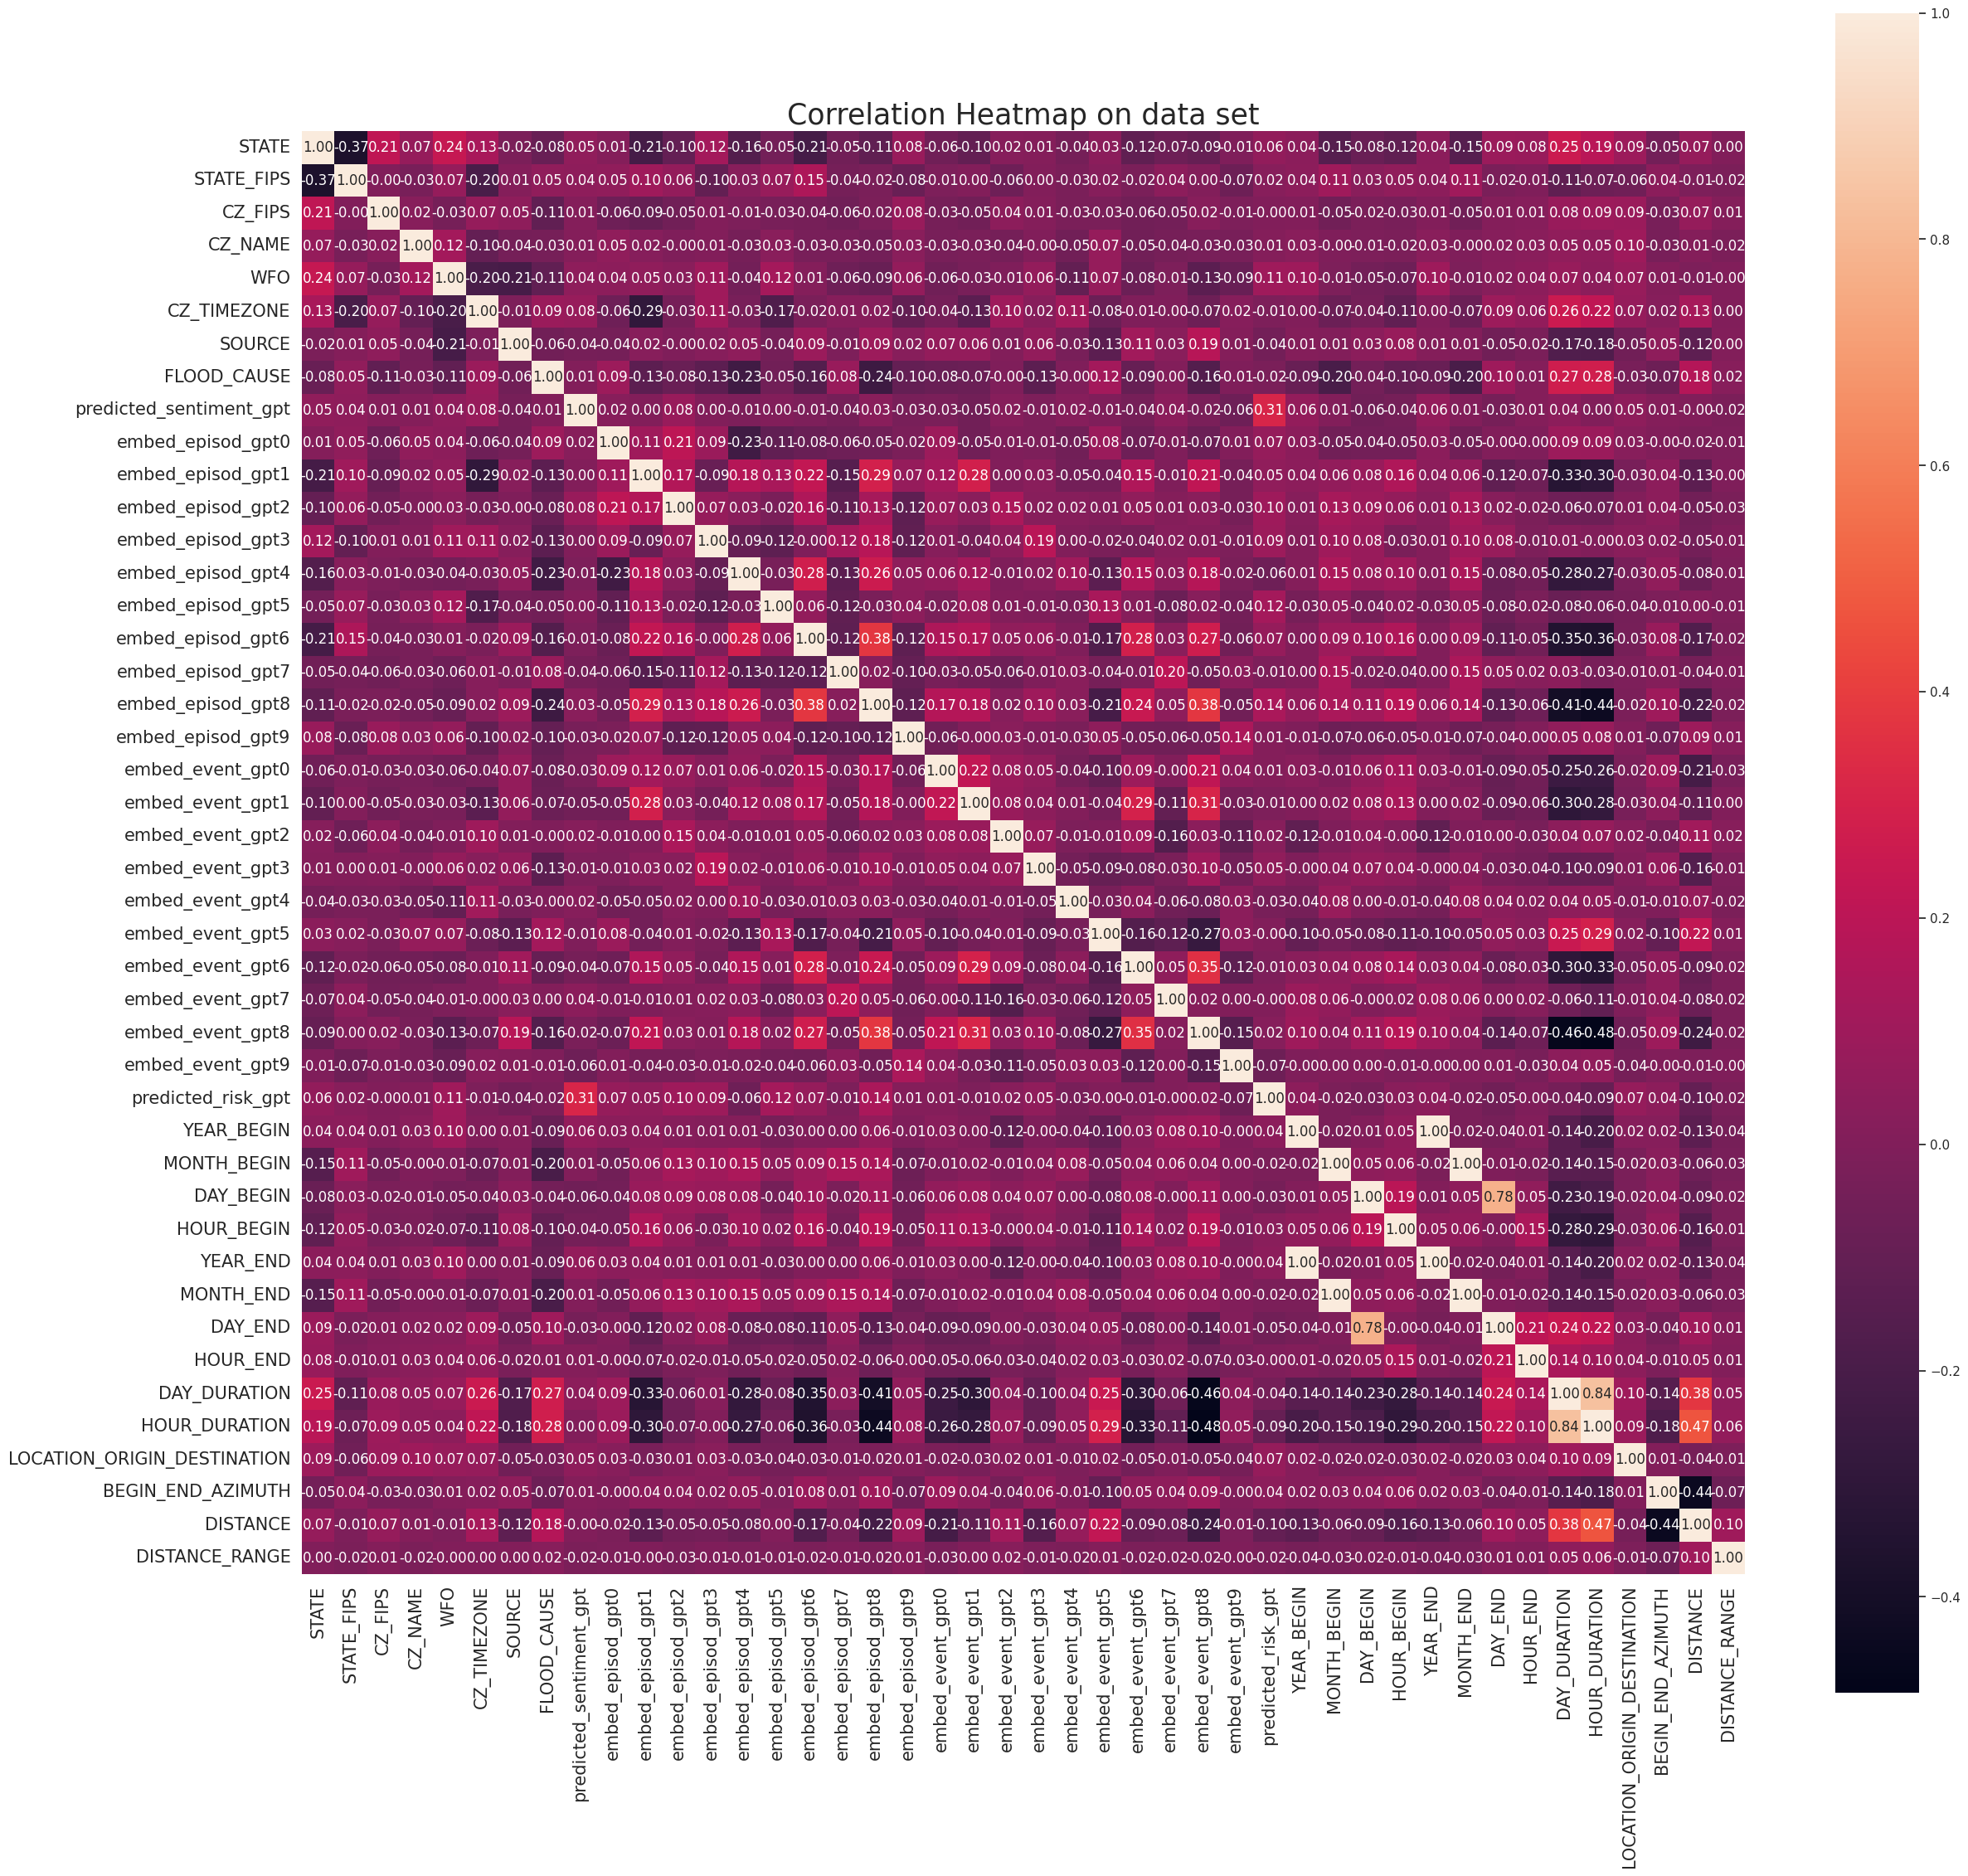

In [ ]:
# Correlation heatmap
corr_matrix = X_all.corr(method='spearman')
sns.set( rc = {'figure.figsize': (25, 25)})
sns.heatmap(corr_matrix, square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=25)
plt.yticks(fontsize="15")
plt.xticks(fontsize="15")
plt.show()

In [ ]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['YEAR_END', 'MONTH_END', 'DAY_END', 'HOUR_DURATION']

In [ ]:
# Drop features
X_all_f = X_all.drop(X_all[to_drop], axis=1)

In [ ]:
# Look at the new features data set
X_all_f.shape

(38014, 40)

### Feature Engineering with Lag and Rolling Window Features

In [ ]:
# Lag Features function
def lag_feat(df, var):
  df_lag = df.copy()
  lags = [1,7,30,90, 180, 270, 365]
  outcomes = [var]
  df_lag=df_lag.assign(**{
      f'{col} (t-{lag})': df_lag[col].shift(lag)
      for lag in lags
      for col in outcomes})
  # Remove nan values
  df_lag = df_lag.dropna()
  return df_lag

In [ ]:
# Rolling features function
def win_feat(df_lag, var):
  windows = [7, 30]
  outcomes = [var]
  df_lag_win = df_lag.copy()
  for window in windows:
    for col in outcomes:
        df_lag_win[f"{col} (r_w-{window}) mean"] = df_lag_win[col].rolling(window=window).mean()
  # Remove nan values
  df_lag_win = df_lag_win.dropna()
  return df_lag_win


In [ ]:
all = pd.concat([target, X_all_f], axis=1)


### Split data set

In [ ]:
# Split data set into train and test sets
train = all[all.index < '2020-01-01']
test = all[all.index >= '2020-01-01']

# Further split test set into individual years
test_2020 = test[test.index < '2021-01-01']
test_2021 = test[(test.index >= '2021-01-01') & (test.index < '2022-01-01')]
test_2022 = test[(test.index >= '2022-01-01') & (test.index < '2023-01-01')]


len(train), len(test), len(test_2020), len(test_2021), len(test_2022)

(31561, 6453, 2549, 2011, 1893)

In [ ]:
# create lag and rolling window features on all dataset for t+1
all_t_1=pd.concat([train,test_2020],axis=0)
all_lag_t_1=lag_feat(all_t_1, 'WHOLE_INJURIES')
all_win_lag_t_1=win_feat(all_lag_t_1,'WHOLE_INJURIES')

# Split data set into train and test sets for t+1
train_t_1 = all_win_lag_t_1[all_win_lag_t_1.index < '2020-01-01']
test_t_1 = all_win_lag_t_1[all_win_lag_t_1.index >= '2020-01-01']

# split features from target for t+1
X_train_t_1 = train_t_1.copy()
y_train_t_1 = X_train_t_1.WHOLE_INJURIES
y_train_t_1 = pd.DataFrame(y_train_t_1, columns=['WHOLE_INJURIES'])
X_train_t_1.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_1 = test_t_1.copy()
y_test_t_1 = X_test_t_1.WHOLE_INJURIES
y_test_t_1 = pd.DataFrame(y_test_t_1, columns=['WHOLE_INJURIES'])
X_test_t_1.drop(['WHOLE_INJURIES'], axis=1, inplace=True)



In [ ]:
# Apply the function to each row to create the exposure column
X_train_t_1['EXPOSURE'] = train_t_1.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
train_exposure_t_1=X_train_t_1.EXPOSURE
X_train_t_1.drop(['EXPOSURE'], axis=1, inplace=True)
X_test_t_1['EXPOSURE'] = X_test_t_1.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_1=X_test_t_1.EXPOSURE
X_test_t_1.drop(['EXPOSURE'], axis=1, inplace=True)





### Modelling & Evaluation

### GLM

#### Fine-Tuning

In [ ]:
# Fine tuning
#def objective(trial):
#    params = {
#        'power': trial.suggest_loguniform('power', 1, 1.5),
#         'alpha': trial.suggest_loguniform('alpha', 1e-4, 1.0),
#        'link':'log'
#    }
#    np.random.seed(0)
#    glm = TweedieRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)
#    mpd_scores = []

#    for train_index, val_index in tscv.split(X_train_t_1):
#        X_tr, X_val, tr_exposure, val_exposure = X_train_t_1.iloc[train_index], X_train_t_1.iloc[val_index], train_exposure_t_1[train_index], train_exposure_t_1[val_index]
#        y_tr, y_val = y_train_t_1.iloc[train_index], y_train_t_1.iloc[val_index]

#        glm.fit(X_tr, y_tr.squeeze()/tr_exposure.values, sample_weight=tr_exposure.values)
#        pred_val = glm.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params



In [ ]:
#best_params

### Fit the model

In [ ]:
np.random.seed(0)
glm_tuned = TweedieRegressor(power=1.1865168914030164, alpha=0.001173817241965477, link='log') # GLM with compound Poisson-Gamma distribution
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
glm_model = GridSearchCV(glm_tuned,param_grid,cv=tscv)
glm_fitted=glm_model.fit(X_train_t_1, y_train_t_1.squeeze()/train_exposure_t_1.values,sample_weight=train_exposure_t_1.values)


#### Prediction step 1

In [ ]:
# Prediction t+1
score_glm_t_1 = []
predictions_tr_glm_t_1 = glm_fitted.predict(X_train_t_1)
predictions_te_glm_t_1 = glm_fitted.predict(X_test_t_1)
rmse_train = np.sqrt(mean_squared_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_glm_t_1))
rmse_test = np.sqrt(mean_squared_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_glm_t_1))
mae_train = mean_absolute_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_glm_t_1)
mae_test = mean_absolute_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_glm_t_1)
mpd_train = mean_poisson_deviance(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_glm_t_1)
mpd_test = mean_poisson_deviance(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_glm_t_1)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_glm_t_1.append(score_dict)
score_glm_t_1 = pd.DataFrame(score_glm_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_glm_t_1 = pd.DataFrame(predictions_tr_glm_t_1*train_exposure_t_1.values, columns = ['WHOLE_INJURIES_glm'])
predictions_te_glm_t_1 = pd.DataFrame(predictions_te_glm_t_1*test_exposure_t_1.values, columns = ['WHOLE_INJURIES_glm'])


#### Evaluation step 1

In [ ]:
glm_results_t_1 = {'step':['t+1'],
                'model':['glm'],
               'rmse_train':score_glm_t_1['rmse_train'],
               'rmse_test': score_glm_t_1['rmse_test'],
              'mae_train': score_glm_t_1['mae_train'],
              'mae_test': score_glm_t_1['mae_test'],
               'mpd_train': score_glm_t_1['mpd_train'],
               'mpd_test': score_glm_t_1['mpd_test']
               }
score_glm_t_1 = pd.DataFrame(glm_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_glm_t_1

step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+1   glm      0.0008   0.000026   0.000025  0.000007    0.00026  0.000017

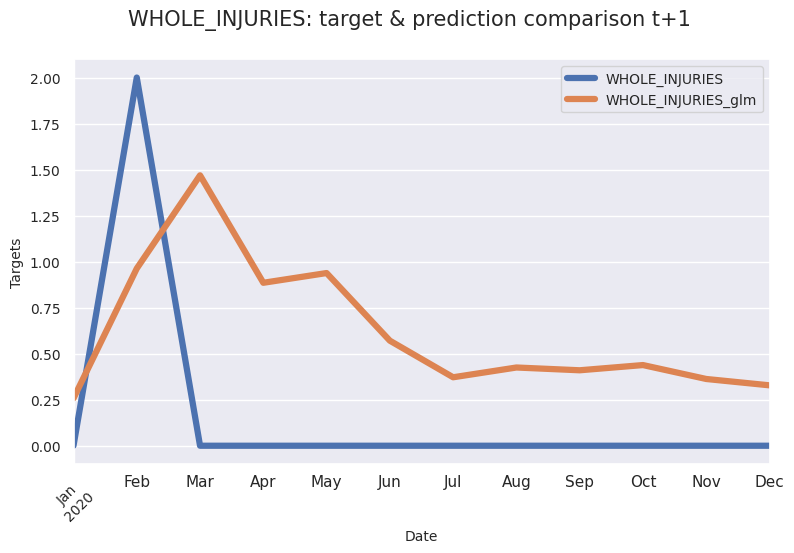

In [ ]:
# Plot results
test_df_glm_t_1=test_2020.copy()
test_df_glm_t_1 = pd.concat([test_df_glm_t_1, predictions_te_glm_t_1.set_index(test_df_glm_t_1.index)], axis=1)
test_df_glm_t_1_agg = test_df_glm_t_1.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_glm_t_1_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction Step 2

In [ ]:
# create lag and window features on all dataset for t+2
test_df_pred_glm_t_1 = test_df_glm_t_1.copy()
test_df_pred_glm_t_1.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_glm_t_1.rename(columns={'WHOLE_INJURIES_glm': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+2
all_t_2=pd.concat([train,test_df_pred_glm_t_1,test_2021],axis=0)
all_lag_t_2=lag_feat(all_t_2, 'WHOLE_INJURIES')
all_win_lag_t_2=win_feat(all_lag_t_2,'WHOLE_INJURIES')

# retrieve test set for t+2
test_t_2 = all_win_lag_t_2[(all_win_lag_t_2.index >= '2021-01-01') & (all_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_t_2 = test_t_2.copy()
y_test_t_2 = X_test_t_2.WHOLE_INJURIES
y_test_t_2 = pd.DataFrame(y_test_t_2, columns=['WHOLE_INJURIES'])
X_test_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_2['EXPOSURE'] = X_test_t_2.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_2=X_test_t_2.EXPOSURE
X_test_t_2.drop(['EXPOSURE'], axis=1, inplace=True)


In [ ]:
score_glm_t_2 = []
predictions_te_glm_t_2 = glm_fitted.predict(X_test_t_2)
rmse_test = np.sqrt(mean_squared_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_glm_t_2))
mae_test = mean_absolute_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_glm_t_2)
mpd_test = mean_poisson_deviance(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_glm_t_2)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_glm_t_2.append(score_dict)
score_glm_t_2 = pd.DataFrame(score_glm_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_glm_t_2 = pd.DataFrame(predictions_te_glm_t_2*test_exposure_t_2.values, columns = ['WHOLE_INJURIES_glm'])


#### Evaluation step 2

In [ ]:
glm_results_t_2 = {'step':['t+2'],
                'model':['glm'],
               'rmse_train':score_glm_t_2['rmse_train'],
               'rmse_test': score_glm_t_2['rmse_test'],
              'mae_train': score_glm_t_2['mae_train'],
              'mae_test': score_glm_t_2['mae_test'],
               'mpd_train': score_glm_t_2['mpd_train'],
               'mpd_test': score_glm_t_2['mpd_test']
               }
score_glm_t_2 = pd.DataFrame(glm_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_glm_t_2

step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+2   glm      0.0008   0.000629   0.000025  0.000026    0.00026  0.000293

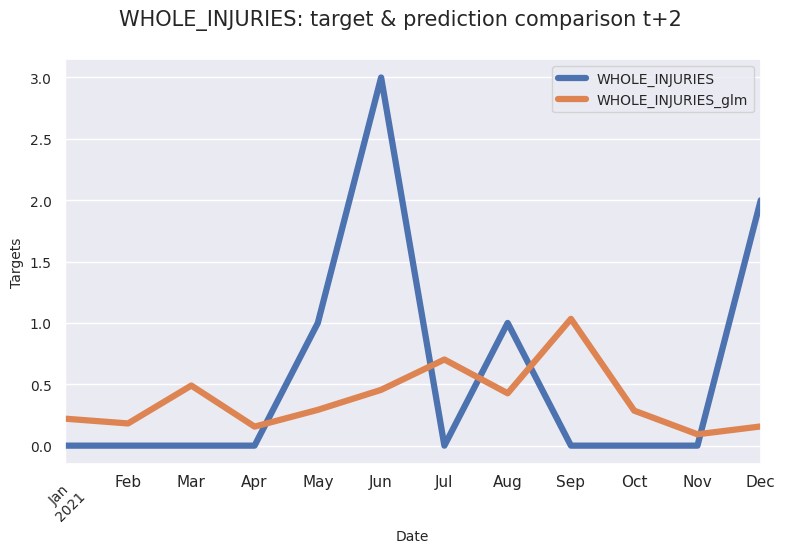

In [ ]:
# Plot results
test_df_glm_t_2=test_2021.copy()
test_df_glm_t_2 = pd.concat([test_df_glm_t_2, predictions_te_glm_t_2.set_index(test_df_glm_t_2.index)], axis=1)
test_df_glm_t_2_agg = test_df_glm_t_2.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_glm_t_2_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

#### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+3
test_df_pred_glm_t_2 = test_df_glm_t_2.copy()
test_df_pred_glm_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_glm_t_2.rename(columns={'WHOLE_INJURIES_glm': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+3
all_t_3=pd.concat([train,test_df_pred_glm_t_1,test_df_pred_glm_t_2,test_2022],axis=0)
all_lag_t_3=lag_feat(all_t_3, 'WHOLE_INJURIES')
all_win_lag_t_3=win_feat(all_lag_t_3,'WHOLE_INJURIES')

# retrieve test set for t+3
test_t_3 = all_win_lag_t_3[(all_win_lag_t_3.index >= '2022-01-01') & (all_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+3
X_test_t_3 = test_t_3.copy()
y_test_t_3 = X_test_t_3.WHOLE_INJURIES
y_test_t_3 = pd.DataFrame(y_test_t_3, columns=['WHOLE_INJURIES'])
X_test_t_3.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_3['EXPOSURE'] = X_test_t_3.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_3=X_test_t_3.EXPOSURE
X_test_t_3.drop(['EXPOSURE'], axis=1, inplace=True)



In [ ]:
score_glm_t_3 = []
predictions_te_glm_t_3 = glm_fitted.predict(X_test_t_3)
rmse_test = np.sqrt(mean_squared_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_glm_t_3))
mae_test = mean_absolute_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_glm_t_3)
mpd_test = mean_poisson_deviance(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_glm_t_3)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_glm_t_3.append(score_dict)
score_glm_t_3 = pd.DataFrame(score_glm_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_glm_t_3 = pd.DataFrame(predictions_te_glm_t_3*test_exposure_t_3.values, columns = ['WHOLE_INJURIES_glm'])



#### Evaluation step 3

In [ ]:
glm_results_t_3 = {'step':['t+3'],
                'model':['glm'],
               'rmse_train':score_glm_t_3['rmse_train'],
               'rmse_test': score_glm_t_3['rmse_test'],
              'mae_train': score_glm_t_3['mae_train'],
              'mae_test': score_glm_t_3['mae_test'],
               'mpd_train': score_glm_t_3['mpd_train'],
               'mpd_test': score_glm_t_3['mpd_test']
               }
score_glm_t_3 = pd.DataFrame(glm_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_glm_t_3

step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+3   glm      0.0008   0.000255   0.000025  0.000013    0.00026  0.000098

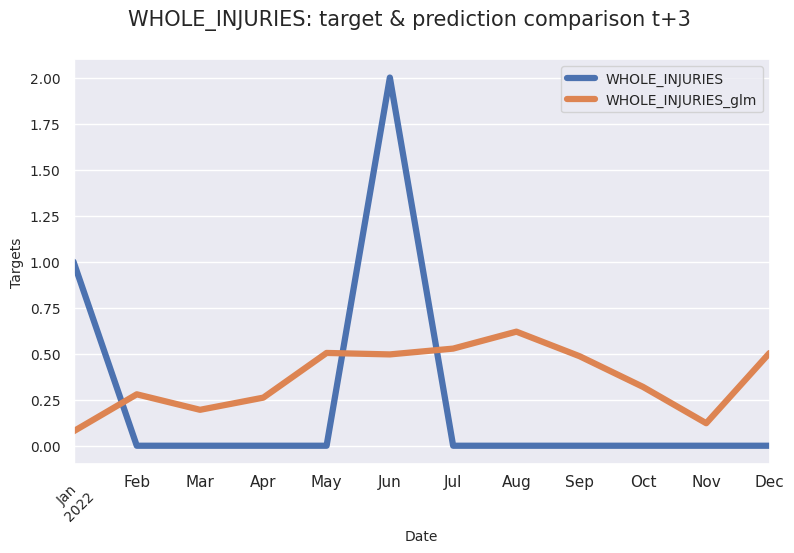

In [ ]:
# Plot results
test_df_glm_t_3=test_2022.copy()
test_df_glm_t_3 = pd.concat([test_df_glm_t_3, predictions_te_glm_t_3.set_index(test_df_glm_t_3.index)], axis=1)
test_df_glm_t_3_agg = test_df_glm_t_3.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_glm_t_3_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

### GAM

In [ ]:
# Initialize H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         6 mins 48 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.5
H2O_cluster_version_age:    20 days
H2O_cluster_name:           H2O_from_python_unknownUser_tvl4nu
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    13.07 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

### Fine-Tuning the model





In [ ]:
# Combine your training and test data
train_data = pd.concat([X_train_t_1, train_exposure_t_1, y_train_t_1], axis=1)
train_h2o_t_1 = h2o.H2OFrame(train_data)

test_data = pd.concat([X_test_t_1, test_exposure_t_1, y_test_t_1], axis=1)
test_h2o_t_1 = h2o.H2OFrame(test_data)

# Specify the columns for x and y
x = X_train_t_1.columns.tolist()
y = 'target'
weights_column = 'EXPOSURE'

# Add the 'target' column to the H2OFrame
train_h2o_t_1[y] = train_h2o_t_1['WHOLE_INJURIES'] / train_h2o_t_1[weights_column]

# Specify the gam_columns
gam_columns = ['STATE_FIPS', 'CZ_FIPS','YEAR_BEGIN', 'MONTH_BEGIN', 'DAY_BEGIN',
               'HOUR_BEGIN','HOUR_END', 'DISTANCE',
               'embed_episod_gpt0', 'embed_episod_gpt1', 'embed_episod_gpt2',
               'embed_episod_gpt3', 'embed_episod_gpt4', 'embed_episod_gpt5',
               'embed_episod_gpt6','embed_episod_gpt7', 'embed_episod_gpt8',
               'embed_episod_gpt9', 'embed_event_gpt0','embed_event_gpt1',
               'embed_event_gpt2', 'embed_event_gpt3', 'embed_event_gpt4',
               'embed_event_gpt5', 'embed_event_gpt6', 'embed_event_gpt7',
               'embed_event_gpt8','embed_event_gpt9']

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Fine-tuning
#def objective(trial):
    # Define the hyperparameter search space
#    alpha = trial.suggest_float('alpha', 0.0, 0.4)
#    lambda_ = trial.suggest_loguniform('lambda', 1e-5, 0.5)


    # Define and train the model
#    gam_model = H2OGeneralizedAdditiveEstimator(
#        family='poisson',
#        seed=0,
#        nfolds=5,
#        weights_column=weights_column,
#        gam_columns=gam_columns,
#        alpha=alpha,
#        lambda_=lambda_,
#        max_iterations=1
#    )

    # Train the model
#    gam_model.train(x=x, y=y, training_frame=train_h2o_t_1)

    # Make predictions
#    predictions_test = gam_model.predict(test_h2o_t_1).as_data_frame().values.flatten()

    # Calculate evaluation metrics
#    rmse = np.sqrt(mean_squared_error(y_test_t_1.squeeze() / test_exposure_t_1.values, predictions_test))

#    return rmse




# Create optuna study and optimize
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)


In [ ]:
# Print best hyperparameters
#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))
#print("  Params: ")
#for key, value in trial.params.items():
#    print(f"    {key}: {value}")

### Fit the model

In [ ]:
# Train the GAM model
gam_model = H2OGeneralizedAdditiveEstimator(family='poisson',
                                            seed=0,
                                            nfolds=5,
                                            weights_column=weights_column,
                                            alpha=0.33951377612937106,
                                            lambda_=0.009373134816118893,
                                            max_iterations=1,
                                            gam_columns=gam_columns)

gam_fitted=gam_model.train(x=x, y=y, training_frame=train_h2o_t_1)



gam Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


### Prediction step 1

In [ ]:
# Make predictions
score_gam_t_1 = []
predictions_tr_gam_t_1 = gam_fitted.predict(train_h2o_t_1).as_data_frame().values.flatten()
predictions_te_gam_t_1 = gam_fitted.predict(test_h2o_t_1).as_data_frame().values.flatten()

# Calculate evaluation metrics
rmse_train = np.sqrt(mean_squared_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_gam_t_1))
rmse_test = np.sqrt(mean_squared_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_gam_t_1))
mae_train = mean_absolute_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_gam_t_1)
mae_test = mean_absolute_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_gam_t_1)
mpd_train = mean_poisson_deviance(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_gam_t_1)
mpd_test = mean_poisson_deviance(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_gam_t_1)

score_dict = {
    'rmse_train': rmse_train,
    'rmse_test': rmse_test,
    'mae_train': mae_train,
    'mae_test': mae_test,
    'mpd_train': mpd_train,
    'mpd_test': mpd_test
}


score_gam_t_1.append(score_dict)
score_gam_t_1 = pd.DataFrame(score_gam_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_gam_t_1 = pd.DataFrame(predictions_tr_gam_t_1*train_exposure_t_1.values, columns = ['WHOLE_INJURIES_gam'])
predictions_te_gam_t_1 = pd.DataFrame(predictions_te_gam_t_1*test_exposure_t_1.values, columns = ['WHOLE_INJURIES_gam'])






gam prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gam prediction progress: |

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Evaluation step 1

In [ ]:
gam_results_t_1 = {'step':['t+1'],
                'model':['gam'],
               'rmse_train':score_gam_t_1['rmse_train'],
               'rmse_test': score_gam_t_1['rmse_test'],
              'mae_train': score_gam_t_1['mae_train'],
              'mae_test': score_gam_t_1['mae_test'],
               'mpd_train': score_gam_t_1['mpd_train'],
               'mpd_test': score_gam_t_1['mpd_test']
               }
score_gam_t_1 = pd.DataFrame(gam_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_gam_t_1


step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+1   gam    0.000801   0.000026   0.000023  0.000005   0.000292  0.000015

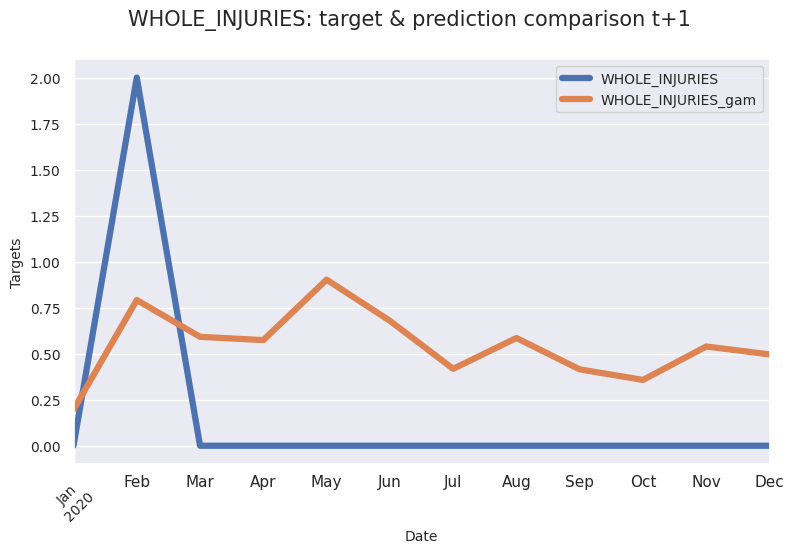

In [ ]:
# Plot results
test_df_gam_t_1=test_2020.copy()
test_df_gam_t_1 = pd.concat([test_df_gam_t_1, predictions_te_gam_t_1.set_index(test_df_gam_t_1.index)], axis=1)
test_df_gam_t_1_agg = test_df_gam_t_1.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_gam': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_gam_t_1_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


### Prediction step 2

In [ ]:
# create lag and window features on all dataset for t+2
test_df_pred_gam_t_1 = test_df_gam_t_1.copy()
test_df_pred_gam_t_1.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_gam_t_1.rename(columns={'WHOLE_INJURIES_gam': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+2
all_t_2=pd.concat([train,test_df_pred_gam_t_1,test_2021],axis=0)
all_lag_t_2=lag_feat(all_t_2, 'WHOLE_INJURIES')
all_win_lag_t_2=win_feat(all_lag_t_2,'WHOLE_INJURIES')

# retrieve test set for t+2
test_t_2 = all_win_lag_t_2[(all_win_lag_t_2.index >= '2021-01-01') & (all_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_t_2 = test_t_2.copy()
y_test_t_2 = X_test_t_2.WHOLE_INJURIES
y_test_t_2 = pd.DataFrame(y_test_t_2, columns=['WHOLE_INJURIES'])
X_test_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_2['EXPOSURE'] = X_test_t_2.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_2=X_test_t_2.EXPOSURE
X_test_t_2.drop(['EXPOSURE'], axis=1, inplace=True)

# Combine your test data t+2
test_data = pd.concat([X_test_t_2, y_test_t_2], axis=1)
test_h2o_t_2 = h2o.H2OFrame(test_data)




Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
score_gam_t_2 = []
predictions_te_gam_t_2 = gam_fitted.predict(test_h2o_t_2).as_data_frame().values.flatten()

rmse_test = np.sqrt(mean_squared_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_gam_t_2))
mae_test = mean_absolute_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_gam_t_2)
mpd_test = mean_poisson_deviance(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_gam_t_2)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_gam_t_2.append(score_dict)
score_gam_t_2 = pd.DataFrame(score_gam_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_gam_t_2 = pd.DataFrame(predictions_te_gam_t_2*test_exposure_t_2.values, columns = ['WHOLE_INJURIES_gam'])



gam prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Evaluation step 2

In [ ]:
gam_results_t_2 = {'step':['t+2'],
                'model':['gam'],
               'rmse_train':score_gam_t_2['rmse_train'],
               'rmse_test': score_gam_t_2['rmse_test'],
              'mae_train': score_gam_t_2['mae_train'],
              'mae_test': score_gam_t_2['mae_test'],
               'mpd_train': score_gam_t_2['mpd_train'],
               'mpd_test': score_gam_t_2['mpd_test']
               }
score_gam_t_2 = pd.DataFrame(gam_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_gam_t_2


step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+2   gam    0.000801   0.000629   0.000023  0.000024   0.000292  0.000302

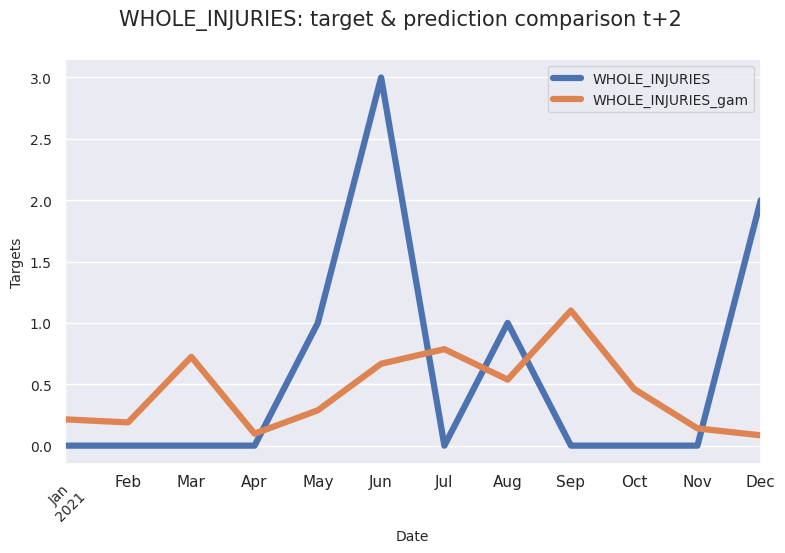

In [ ]:
# Plot results
test_df_gam_t_2=test_2021.copy()
test_df_gam_t_2 = pd.concat([test_df_gam_t_2, predictions_te_gam_t_2.set_index(test_df_gam_t_2.index)], axis=1)
test_df_gam_t_2_agg = test_df_gam_t_2.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_gam': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_gam_t_2_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+3
test_df_pred_gam_t_2 = test_df_gam_t_2.copy()
test_df_pred_gam_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_gam_t_2.rename(columns={'WHOLE_INJURIES_gam': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+3
all_t_3=pd.concat([train,test_df_pred_gam_t_1,test_df_pred_gam_t_2,test_2022],axis=0)
all_lag_t_3=lag_feat(all_t_3, 'WHOLE_INJURIES')
all_win_lag_t_3=win_feat(all_lag_t_3,'WHOLE_INJURIES')

# retrieve test set for t+3
test_t_3 = all_win_lag_t_3[(all_win_lag_t_3.index >= '2022-01-01') & (all_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+3
X_test_t_3 = test_t_3.copy()
y_test_t_3 = X_test_t_3.WHOLE_INJURIES
y_test_t_3 = pd.DataFrame(y_test_t_3, columns=['WHOLE_INJURIES'])
X_test_t_3.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_3['EXPOSURE'] = X_test_t_3.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_3=X_test_t_3.EXPOSURE
X_test_t_3.drop(['EXPOSURE'], axis=1, inplace=True)

# Combine your test data t+3
test_data = pd.concat([X_test_t_3, y_test_t_3], axis=1)
test_h2o_t_3 = h2o.H2OFrame(test_data)



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
score_gam_t_3 = []
predictions_te_gam_t_3 = gam_fitted.predict(test_h2o_t_3).as_data_frame().values.flatten()

rmse_test = np.sqrt(mean_squared_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_gam_t_3))
mae_test = mean_absolute_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_gam_t_3)
mpd_test = mean_poisson_deviance(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_gam_t_3)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_gam_t_3.append(score_dict)
score_gam_t_3 = pd.DataFrame(score_gam_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_gam_t_3 = pd.DataFrame(predictions_te_gam_t_3*test_exposure_t_3.values, columns = ['WHOLE_INJURIES_gam'])



gam prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Evaluation step 3

In [ ]:
gam_results_t_3 = {'step':['t+3'],
                'model':['gam'],
               'rmse_train':score_gam_t_3['rmse_train'],
               'rmse_test': score_gam_t_3['rmse_test'],
              'mae_train': score_gam_t_3['mae_train'],
              'mae_test': score_gam_t_3['mae_test'],
               'mpd_train': score_gam_t_3['mpd_train'],
               'mpd_test': score_gam_t_3['mpd_test']
               }
score_gam_t_3 = pd.DataFrame(gam_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_gam_t_3



step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+3   gam    0.000801   0.000254   0.000023  0.000011   0.000292  0.000099

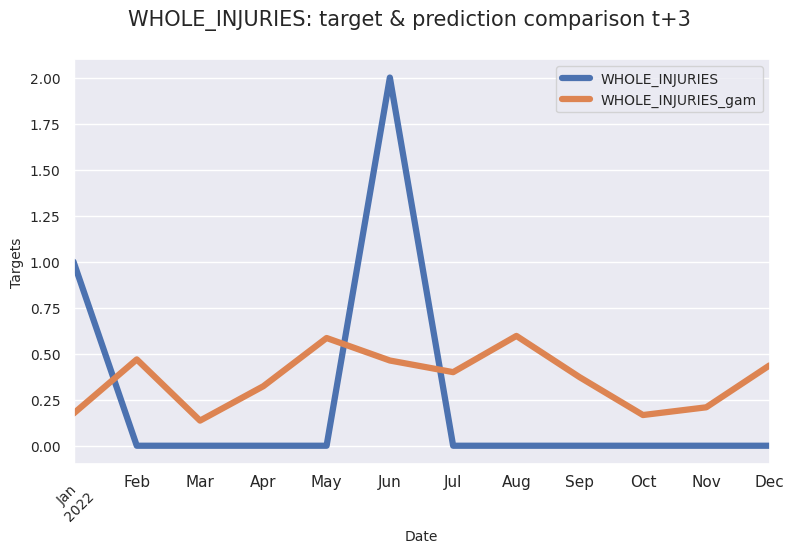

In [ ]:
# Plot results
test_df_gam_t_3=test_2022.copy()
test_df_gam_t_3 = pd.concat([test_df_gam_t_3, predictions_te_gam_t_3.set_index(test_df_gam_t_3.index)], axis=1)
test_df_gam_t_3_agg = test_df_gam_t_3.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_gam': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_gam_t_3_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()






### LightGBM

#### Fine-tuning the model

In [ ]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'objective': 'poisson',
#        'random_state': 0,
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 8),
#        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
#        'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.1, 1.0)
#    }

#    lgbm = LGBMRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mpd_scores = []


#    for train_index, val_index in tscv.split(X_train_t_1):
#        X_tr, X_val, tr_exposure, val_exposure = X_train_t_1.iloc[train_index], X_train_t_1.iloc[val_index], train_exposure_t_1[train_index], train_exposure_t_1[val_index]
#        y_tr, y_val = y_train_t_1.iloc[train_index], y_train_t_1.iloc[val_index]

#        lgbm.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure)
#        pred_val = lgbm.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params



In [ ]:
#best_params

#### Fit the model

In [ ]:
lgbm_tuned =  LGBMRegressor(
    n_estimators= 531,
    learning_rate= 0.01081472083688828,
    max_depth= 6,
    num_leaves= 82,
    min_child_samples= 91,
    min_data_in_leaf= 54,
    bagging_fraction= 0.68241774525966692,
    objective='poisson',
    verbose= 0,
    random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
lgbm_model = GridSearchCV(lgbm_tuned,param_grid,cv=tscv)
lgbm_fitted=lgbm_model.fit(X_train_t_1, y_train_t_1.squeeze()/train_exposure_t_1.values,
               sample_weight=train_exposure_t_1.values)




[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.6824177452596669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6824177452596669
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.6824177452596669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6824177452596669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

### Prediction step 1

In [ ]:
# Prediction t+1
score_lgbm_t_1 = []
predictions_tr_lgbm_t_1 = lgbm_fitted.predict(X_train_t_1)
predictions_te_lgbm_t_1 = lgbm_fitted.predict(X_test_t_1)
rmse_train = np.sqrt(mean_squared_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_lgbm_t_1))
rmse_test = np.sqrt(mean_squared_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_lgbm_t_1))
mae_train = mean_absolute_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_lgbm_t_1)
mae_test = mean_absolute_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_lgbm_t_1)
mpd_train = mean_poisson_deviance(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_lgbm_t_1)
mpd_test = mean_poisson_deviance(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_lgbm_t_1)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_lgbm_t_1.append(score_dict)
score_lgbm_t_1 = pd.DataFrame(score_lgbm_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_lgbm_t_1 = pd.DataFrame(predictions_tr_lgbm_t_1*train_exposure_t_1.values, columns = ['WHOLE_INJURIES_lgbm'])
predictions_te_lgbm_t_1 = pd.DataFrame(predictions_te_lgbm_t_1*test_exposure_t_1.values, columns = ['WHOLE_INJURIES_lgbm'])




[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.6824177452596669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6824177452596669
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.6824177452596669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6824177452596669


### Evaluation step 1

In [ ]:
lgbm_results_t_1 = {'step':['t+1'],
                'model':['lgbm'],
               'rmse_train':score_lgbm_t_1['rmse_train'],
               'rmse_test': score_lgbm_t_1['rmse_test'],
              'mae_train': score_lgbm_t_1['mae_train'],
              'mae_test': score_lgbm_t_1['mae_test'],
               'mpd_train': score_lgbm_t_1['mpd_train'],
               'mpd_test': score_lgbm_t_1['mpd_test']
               }
score_lgbm_t_1 = pd.DataFrame(lgbm_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_lgbm_t_1


step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+1  lgbm    0.000405   0.000027   0.000012  0.000002   0.000022  0.000004

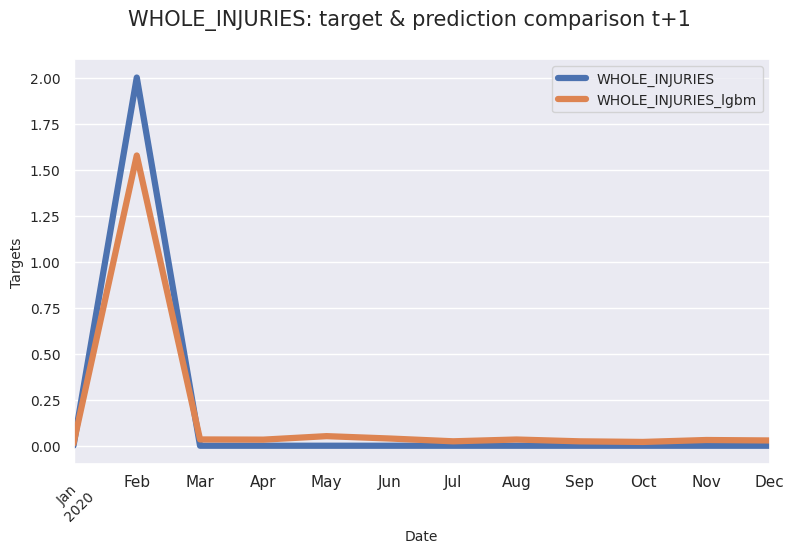

In [ ]:
# Plot results
test_df_lgbm_t_1=test_2020.copy()
test_df_lgbm_t_1 = pd.concat([test_df_lgbm_t_1, predictions_te_lgbm_t_1.set_index(test_df_lgbm_t_1.index)], axis=1)
test_df_lgbm_t_1_agg = test_df_lgbm_t_1.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_lgbm_t_1_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

### Prediction step 2

In [ ]:
# create lag and window features on all dataset for t+2
test_df_pred_lgbm_t_1 = test_df_lgbm_t_1.copy()
test_df_pred_lgbm_t_1.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_lgbm_t_1.rename(columns={'WHOLE_INJURIES_lgbm': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+2
all_t_2=pd.concat([train,test_df_pred_lgbm_t_1,test_2021],axis=0)
all_lag_t_2=lag_feat(all_t_2, 'WHOLE_INJURIES')
all_win_lag_t_2=win_feat(all_lag_t_2,'WHOLE_INJURIES')

# retrieve test set for t+2
test_t_2 = all_win_lag_t_2[(all_win_lag_t_2.index >= '2021-01-01') & (all_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_t_2 = test_t_2.copy()
y_test_t_2 = X_test_t_2.WHOLE_INJURIES
y_test_t_2 = pd.DataFrame(y_test_t_2, columns=['WHOLE_INJURIES'])
X_test_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_2['EXPOSURE'] = X_test_t_2.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_2=X_test_t_2.EXPOSURE
X_test_t_2.drop(['EXPOSURE'], axis=1, inplace=True)



In [ ]:
score_lgbm_t_2 = []
predictions_te_lgbm_t_2 = lgbm_fitted.predict(X_test_t_2)
rmse_test = np.sqrt(mean_squared_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_lgbm_t_2))
mae_test = mean_absolute_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_lgbm_t_2)
mpd_test = mean_poisson_deviance(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_lgbm_t_2)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_lgbm_t_2.append(score_dict)
score_lgbm_t_2 = pd.DataFrame(score_lgbm_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_lgbm_t_2 = pd.DataFrame(predictions_te_lgbm_t_2*test_exposure_t_2.values, columns = ['WHOLE_INJURIES_lgbm'])



[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.6824177452596669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6824177452596669


### Evaluation step 2

In [ ]:
lgbm_results_t_2 = {'step':['t+2'],
                'model':['lgbm'],
               'rmse_train':score_lgbm_t_2['rmse_train'],
               'rmse_test': score_lgbm_t_2['rmse_test'],
              'mae_train': score_lgbm_t_2['mae_train'],
              'mae_test': score_lgbm_t_2['mae_test'],
               'mpd_train': score_lgbm_t_2['mpd_train'],
               'mpd_test': score_lgbm_t_2['mpd_test']
               }
score_lgbm_t_2 = pd.DataFrame(lgbm_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_lgbm_t_2


step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+2  lgbm    0.000405   0.000606   0.000012  0.000023   0.000022  0.000095

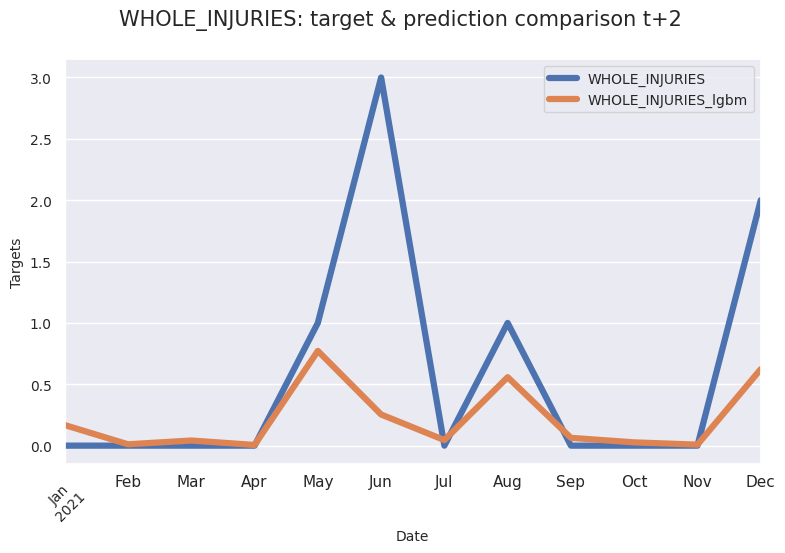

In [ ]:
# Plot results
test_df_lgbm_t_2=test_2021.copy()
test_df_lgbm_t_2 = pd.concat([test_df_lgbm_t_2, predictions_te_lgbm_t_2.set_index(test_df_lgbm_t_2.index)], axis=1)
test_df_lgbm_t_2_agg = test_df_lgbm_t_2.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_lgbm_t_2_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+3
test_df_pred_lgbm_t_2 = test_df_lgbm_t_2.copy()
test_df_pred_lgbm_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_lgbm_t_2.rename(columns={'WHOLE_INJURIES_lgbm': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+3
all_t_3=pd.concat([train,test_df_pred_lgbm_t_1,test_df_pred_lgbm_t_2,test_2022],axis=0)
all_lag_t_3=lag_feat(all_t_3, 'WHOLE_INJURIES')
all_win_lag_t_3=win_feat(all_lag_t_3,'WHOLE_INJURIES')

# retrieve test set for t+3
test_t_3 = all_win_lag_t_3[(all_win_lag_t_3.index >= '2022-01-01') & (all_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+3
X_test_t_3 = test_t_3.copy()
y_test_t_3 = X_test_t_3.WHOLE_INJURIES
y_test_t_3 = pd.DataFrame(y_test_t_3, columns=['WHOLE_INJURIES'])
X_test_t_3.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_3['EXPOSURE'] = X_test_t_3.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_3=X_test_t_3.EXPOSURE
X_test_t_3.drop(['EXPOSURE'], axis=1, inplace=True)


In [ ]:
score_lgbm_t_3 = []
predictions_te_lgbm_t_3 = lgbm_fitted.predict(X_test_t_3)
rmse_test = np.sqrt(mean_squared_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_lgbm_t_3))
mae_test = mean_absolute_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_lgbm_t_3)
mpd_test = mean_poisson_deviance(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_lgbm_t_3)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_lgbm_t_3.append(score_dict)
score_lgbm_t_3 = pd.DataFrame(score_lgbm_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_lgbm_t_3 = pd.DataFrame(predictions_te_lgbm_t_3*test_exposure_t_3.values, columns = ['WHOLE_INJURIES_lgbm'])


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.6824177452596669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6824177452596669


### Evaluation step 3

In [ ]:
lgbm_results_t_3 = {'step':['t+3'],
                'model':['lgbm'],
               'rmse_train':score_lgbm_t_3['rmse_train'],
               'rmse_test': score_lgbm_t_3['rmse_test'],
              'mae_train': score_lgbm_t_3['mae_train'],
              'mae_test': score_lgbm_t_3['mae_test'],
               'mpd_train': score_lgbm_t_3['mpd_train'],
               'mpd_test': score_lgbm_t_3['mpd_test']
               }
score_lgbm_t_3 = pd.DataFrame(lgbm_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_lgbm_t_3



step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+3  lgbm    0.000405   0.000267   0.000012  0.000012   0.000022  0.000038

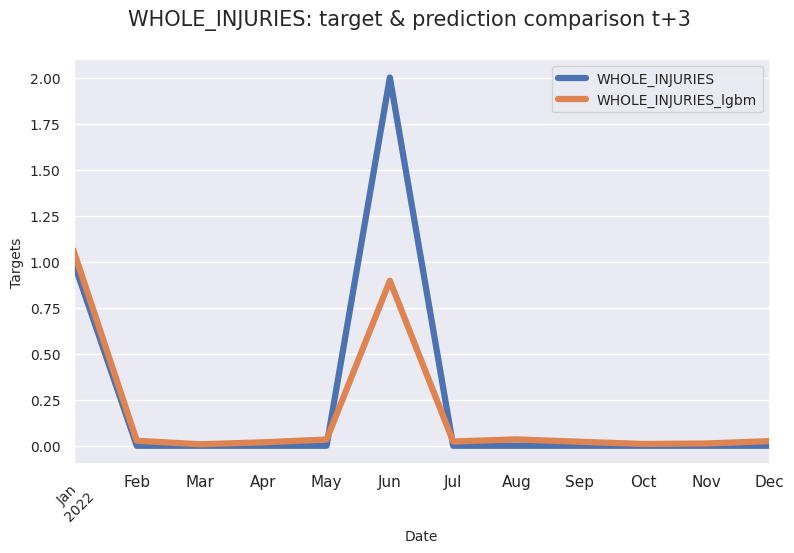

In [ ]:
# Plot results
test_df_lgbm_t_3=test_2022.copy()
test_df_lgbm_t_3 = pd.concat([test_df_lgbm_t_3, predictions_te_lgbm_t_3.set_index(test_df_lgbm_t_3.index)], axis=1)
test_df_lgbm_t_3_agg = test_df_lgbm_t_3.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_lgbm_t_3_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

### XGBoost

#### Fine-tuning the model

In [ ]:
# fine-tuning
#def objective(trial):
#    params = {
#        'objective': 'reg:tweedie',
#        'tweedie_variance_power':1,
#        'random_state': 0,
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 8),
#        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),  # For XGBoost equivalent to min_child_samples
#        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),  # For XGBoost equivalent to bagging_fraction
#        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1.0)  # Adding this as it can be important
#    }

#    xgb = XGBRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mpd_scores = []

#    for train_index, val_index in tscv.split(X_train_t_1):
#        X_tr, X_val, tr_exposure, val_exposure = X_train_t_1.iloc[train_index], X_train_t_1.iloc[val_index], train_exposure_t_1[train_index], train_exposure_t_1[val_index]
#        y_tr, y_val = y_train_t_1.iloc[train_index], y_train_t_1.iloc[val_index]


        # Adjusting the fit to account for sample_weights

#        xgb.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure)
#        pred_val = xgb.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params

In [ ]:
#best_params

#### Fit the model

In [ ]:
# Define the model
xgb_tuned = XGBRegressor(
    n_estimators=370,
    learning_rate=0.034132481826275395,
    max_depth=8,
    min_child_weight=31,
    subsample=0.5146598021347673,
    colsample_bytree=0.2226425942256343,
    objective='reg:tweedie',
    tweedie_variance_power=1,
    verbose=0,
    random_state=0
)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}  # You can still add relevant XGBoost parameters here
xgb_model = GridSearchCV(xgb_tuned, param_grid, cv=tscv)

# Fit the model
xgb_fitted=xgb_model.fit(X_train_t_1, y_train_t_1.squeeze() / train_exposure_t_1.values,
               sample_weight=train_exposure_t_1.values)




### Prediction step 1

In [ ]:
# Prediction t+1
score_xgb_t_1 = []
predictions_tr_xgb_t_1 = xgb_fitted.predict(X_train_t_1)
predictions_te_xgb_t_1 = xgb_fitted.predict(X_test_t_1)
rmse_train = np.sqrt(mean_squared_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_xgb_t_1))
rmse_test = np.sqrt(mean_squared_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_xgb_t_1))
mae_train = mean_absolute_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_xgb_t_1)
mae_test = mean_absolute_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_xgb_t_1)
mpd_train = mean_poisson_deviance(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_xgb_t_1)
mpd_test = mean_poisson_deviance(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_xgb_t_1)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_xgb_t_1.append(score_dict)
score_xgb_t_1 = pd.DataFrame(score_xgb_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_xgb_t_1 = pd.DataFrame(predictions_tr_xgb_t_1*train_exposure_t_1.values, columns = ['WHOLE_INJURIES_xgb'])
predictions_te_xgb_t_1 = pd.DataFrame(predictions_te_xgb_t_1*test_exposure_t_1.values, columns = ['WHOLE_INJURIES_xgb'])


### Evaluation step 1

In [ ]:
xgb_results_t_1 = {'step':['t+1'],
                'model':['xgb'],
               'rmse_train':score_xgb_t_1['rmse_train'],
               'rmse_test': score_xgb_t_1['rmse_test'],
              'mae_train': score_xgb_t_1['mae_train'],
              'mae_test': score_xgb_t_1['mae_test'],
               'mpd_train': score_xgb_t_1['mpd_train'],
               'mpd_test': score_xgb_t_1['mpd_test']
               }
score_xgb_t_1 = pd.DataFrame(xgb_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_xgb_t_1


step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+1   xgb    0.000799   0.000026   0.000026  0.000007   0.000193  0.000016

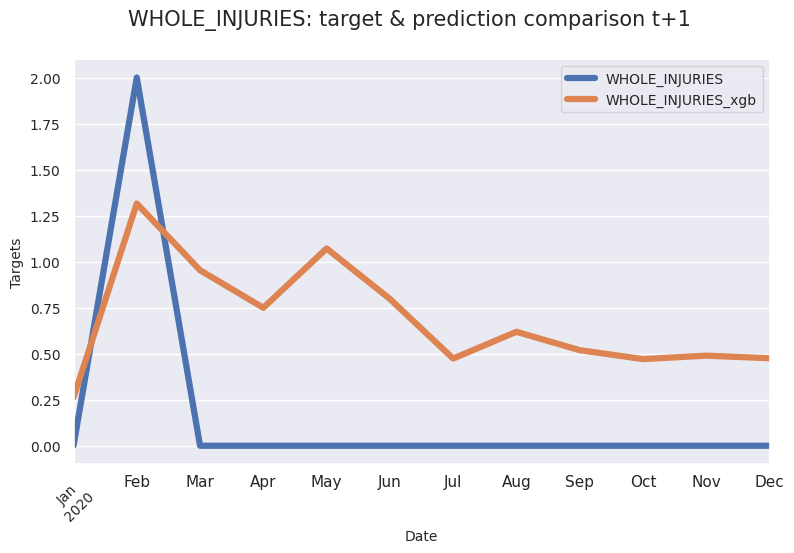

In [ ]:
# Plot results
test_df_xgb_t_1=test_2020.copy()
test_df_xgb_t_1 = pd.concat([test_df_xgb_t_1, predictions_te_xgb_t_1.set_index(test_df_xgb_t_1.index)], axis=1)
test_df_xgb_t_1_agg = test_df_xgb_t_1.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_xgb': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_xgb_t_1_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


### Prediction step 2

In [ ]:
# create lag and window features on all dataset for t+2
test_df_pred_xgb_t_1 = test_df_xgb_t_1.copy()
test_df_pred_xgb_t_1.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_xgb_t_1.rename(columns={'WHOLE_INJURIES_xgb': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+2
all_t_2=pd.concat([train,test_df_pred_xgb_t_1,test_2021],axis=0)
all_lag_t_2=lag_feat(all_t_2, 'WHOLE_INJURIES')
all_win_lag_t_2=win_feat(all_lag_t_2,'WHOLE_INJURIES')

# retrieve test set for t+2
test_t_2 = all_win_lag_t_2[(all_win_lag_t_2.index >= '2021-01-01') & (all_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_t_2 = test_t_2.copy()
y_test_t_2 = X_test_t_2.WHOLE_INJURIES
y_test_t_2 = pd.DataFrame(y_test_t_2, columns=['WHOLE_INJURIES'])
X_test_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_2['EXPOSURE'] = X_test_t_2.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_2=X_test_t_2.EXPOSURE
X_test_t_2.drop(['EXPOSURE'], axis=1, inplace=True)



In [ ]:
score_xgb_t_2 = []
predictions_te_xgb_t_2 = xgb_fitted.predict(X_test_t_2)
rmse_test = np.sqrt(mean_squared_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_xgb_t_2))
mae_test = mean_absolute_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_xgb_t_2)
mpd_test = mean_poisson_deviance(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_xgb_t_2)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_xgb_t_2.append(score_dict)
score_xgb_t_2 = pd.DataFrame(score_xgb_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_xgb_t_2 = pd.DataFrame(predictions_te_xgb_t_2*test_exposure_t_2.values, columns = ['WHOLE_INJURIES_xgb'])



### Evaluation step 2

In [ ]:
xgb_results_t_2 = {'step':['t+2'],
                'model':['xgb'],
               'rmse_train':score_xgb_t_2['rmse_train'],
               'rmse_test': score_xgb_t_2['rmse_test'],
              'mae_train': score_xgb_t_2['mae_train'],
              'mae_test': score_xgb_t_2['mae_test'],
               'mpd_train': score_xgb_t_2['mpd_train'],
               'mpd_test': score_xgb_t_2['mpd_test']
               }
score_xgb_t_2 = pd.DataFrame(xgb_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_xgb_t_2



step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+2   xgb    0.000799   0.000628   0.000026  0.000026   0.000193  0.000227

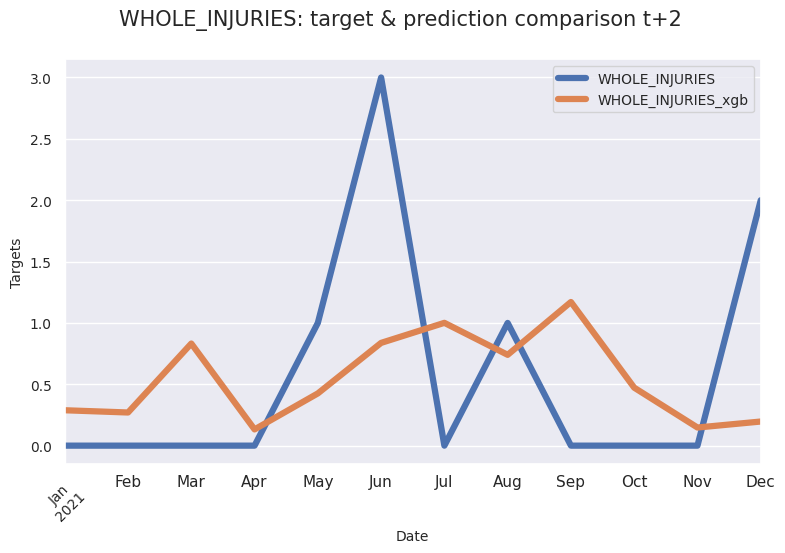

In [ ]:
# Plot results
test_df_xgb_t_2=test_2021.copy()
test_df_xgb_t_2 = pd.concat([test_df_xgb_t_2, predictions_te_xgb_t_2.set_index(test_df_xgb_t_2.index)], axis=1)
test_df_xgb_t_2_agg = test_df_xgb_t_2.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_xgb': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_xgb_t_2_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+3
test_df_pred_xgb_t_2 = test_df_xgb_t_2.copy()
test_df_pred_xgb_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_xgb_t_2.rename(columns={'WHOLE_INJURIES_xgb': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+3
all_t_3=pd.concat([train,test_df_pred_xgb_t_1,test_df_pred_xgb_t_2,test_2022],axis=0)
all_lag_t_3=lag_feat(all_t_3, 'WHOLE_INJURIES')
all_win_lag_t_3=win_feat(all_lag_t_3,'WHOLE_INJURIES')

# retrieve test set for t+3
test_t_3 = all_win_lag_t_3[(all_win_lag_t_3.index >= '2022-01-01') & (all_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+3
X_test_t_3 = test_t_3.copy()
y_test_t_3 = X_test_t_3.WHOLE_INJURIES
y_test_t_3 = pd.DataFrame(y_test_t_3, columns=['WHOLE_INJURIES'])
X_test_t_3.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_3['EXPOSURE'] = X_test_t_3.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_3=X_test_t_3.EXPOSURE
X_test_t_3.drop(['EXPOSURE'], axis=1, inplace=True)



In [ ]:
score_xgb_t_3 = []
predictions_te_xgb_t_3 = xgb_fitted.predict(X_test_t_3)
rmse_test = np.sqrt(mean_squared_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_xgb_t_3))
mae_test = mean_absolute_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_xgb_t_3)
mpd_test = mean_poisson_deviance(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_xgb_t_3)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_xgb_t_3.append(score_dict)
score_xgb_t_3 = pd.DataFrame(score_xgb_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_xgb_t_3 = pd.DataFrame(predictions_te_xgb_t_3*test_exposure_t_3.values, columns = ['WHOLE_INJURIES_xgb'])



### Evaluation step 3

In [ ]:
xgb_results_t_3 = {'step':['t+3'],
                'model':['xgb'],
               'rmse_train':score_xgb_t_3['rmse_train'],
               'rmse_test': score_xgb_t_3['rmse_test'],
              'mae_train': score_xgb_t_3['mae_train'],
              'mae_test': score_xgb_t_3['mae_test'],
               'mpd_train': score_xgb_t_3['mpd_train'],
               'mpd_test': score_xgb_t_3['mpd_test']
               }
score_xgb_t_3 = pd.DataFrame(xgb_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_xgb_t_3


step model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  mpd_test
0  t+3   xgb    0.000799   0.000254   0.000026  0.000013   0.000193  0.000081

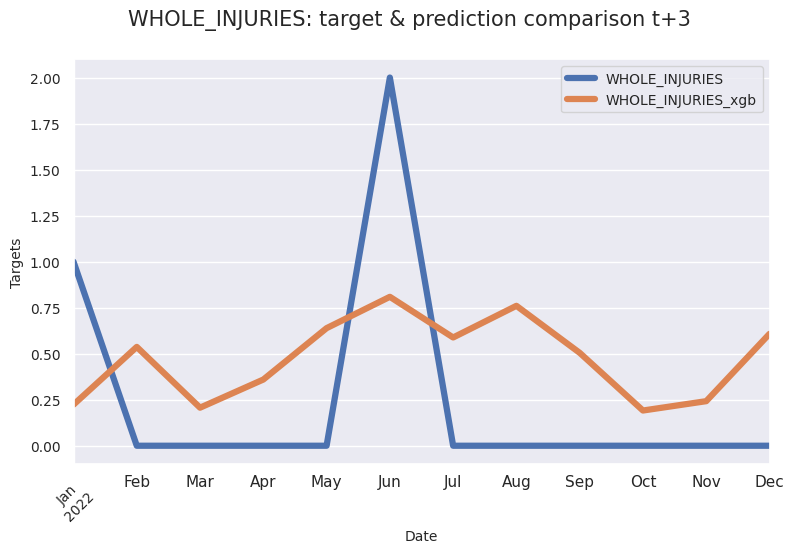

In [ ]:
# Plot results
test_df_xgb_t_3=test_2022.copy()
test_df_xgb_t_3 = pd.concat([test_df_xgb_t_3, predictions_te_xgb_t_3.set_index(test_df_xgb_t_3.index)], axis=1)
test_df_xgb_t_3_agg = test_df_xgb_t_3.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_xgb': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_xgb_t_3_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


### CatBoost

#### Fine-tuning the model

In [ ]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'loss_function': 'Poisson',
#        'random_seed': 0,
#        'iterations': trial.suggest_int('iterations', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'depth': trial.suggest_int('depth', 3, 8),
#        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
#        'rsm': trial.suggest_loguniform('rsm', 0.1, 1.0),
#        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
#        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
#    }

#    if params['bootstrap_type'] == 'Bayesian':
#        params['bagging_temperature'] = trial.suggest_loguniform('bagging_temperature', 0.01, 10.0)
#    elif params['bootstrap_type'] == 'Bernoulli':
#        params['subsample'] = trial.suggest_float('subsample', 0.1, 1.0)

#    catboost = CatBoostRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mpd_scores = []

#    for train_index, val_index in tscv.split(X_train_t_1):
#        X_tr, X_val, tr_exposure, val_exposure = X_train_t_1.iloc[train_index], X_train_t_1.iloc[val_index], train_exposure_t_1[train_index], train_exposure_t_1[val_index]
#        y_tr, y_val = y_train_t_1.iloc[train_index], y_train_t_1.iloc[val_index]

#        catboost.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure, verbose=0)
#        pred_val = catboost.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params

In [ ]:
#best_params

#### Fit the model

In [ ]:
# Define the model
catboost_tuned = CatBoostRegressor(
    iterations=809,
    learning_rate=0.0813162492162555,
    depth=4,
    l2_leaf_reg=1.3730139049265433,
    rsm=0.5261313486994439,
    loss_function='Poisson',
    bootstrap_type= 'Bernoulli',
    grow_policy= 'Depthwise',
    subsample= 0.3191789027758025,
    random_state=0,
    verbose=0
)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}  # Add relevant CatBoost parameters if needed
catboost_model = GridSearchCV(catboost_tuned, param_grid, cv=tscv)

# Fit the model
catboost_fitted=catboost_model.fit(X_train_t_1, y_train_t_1.squeeze() / train_exposure_t_1.values,
                   sample_weight=train_exposure_t_1.values)



### Prediction step 1

In [ ]:
# Prediction t+1
score_catboost_t_1 = []
predictions_tr_catboost_t_1 = catboost_fitted.predict(X_train_t_1)
predictions_te_catboost_t_1 = catboost_fitted.predict(X_test_t_1)
rmse_train = np.sqrt(mean_squared_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_catboost_t_1))
rmse_test = np.sqrt(mean_squared_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_catboost_t_1))
mae_train = mean_absolute_error(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_catboost_t_1)
mae_test = mean_absolute_error(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_catboost_t_1)
mpd_train = mean_poisson_deviance(y_train_t_1.squeeze()/train_exposure_t_1.values, predictions_tr_catboost_t_1)
mpd_test = mean_poisson_deviance(y_test_t_1.squeeze()/test_exposure_t_1.values, predictions_te_catboost_t_1)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_catboost_t_1.append(score_dict)
score_catboost_t_1 = pd.DataFrame(score_catboost_t_1, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_catboost_t_1 = pd.DataFrame(predictions_tr_catboost_t_1*train_exposure_t_1.values, columns = ['WHOLE_INJURIES_catboost'])
predictions_te_catboost_t_1 = pd.DataFrame(predictions_te_catboost_t_1*test_exposure_t_1.values, columns = ['WHOLE_INJURIES_catboost'])


### Evaluation step 1

In [ ]:
catboost_results_t_1 = {'step':['t+1'],
                'model':['catboost'],
               'rmse_train':score_catboost_t_1['rmse_train'],
               'rmse_test': score_catboost_t_1['rmse_test'],
              'mae_train': score_catboost_t_1['mae_train'],
              'mae_test': score_catboost_t_1['mae_test'],
               'mpd_train': score_catboost_t_1['mpd_train'],
               'mpd_test': score_catboost_t_1['mpd_test']
               }
score_catboost_t_1 = pd.DataFrame(catboost_results_t_1,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_catboost_t_1


step     model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  \
0  t+1  catboost     0.00072   0.000026   0.000022  0.000002   0.000072   

   mpd_test  
0  0.000004

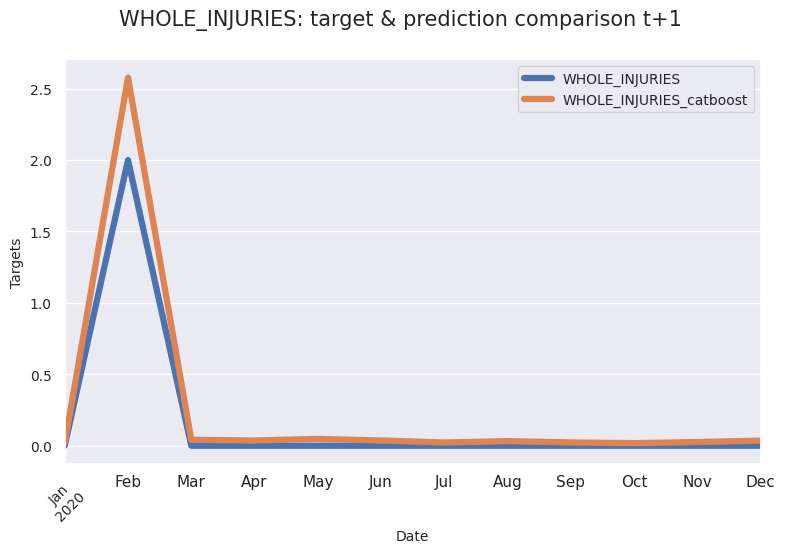

In [ ]:
# Plot results
test_df_catboost_t_1=test_2020.copy()
test_df_catboost_t_1 = pd.concat([test_df_catboost_t_1, predictions_te_catboost_t_1.set_index(test_df_catboost_t_1.index)], axis=1)
test_df_catboost_t_1_agg = test_df_catboost_t_1.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_catboost': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_catboost_t_1_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+1', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()



### Prediction step 2

In [ ]:
# create lag and window features on all dataset for t+2
test_df_pred_catboost_t_1 = test_df_catboost_t_1.copy()
test_df_pred_catboost_t_1.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_catboost_t_1.rename(columns={'WHOLE_INJURIES_catboost': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+2
all_t_2=pd.concat([train,test_df_pred_catboost_t_1,test_2021],axis=0)
all_lag_t_2=lag_feat(all_t_2, 'WHOLE_INJURIES')
all_win_lag_t_2=win_feat(all_lag_t_2,'WHOLE_INJURIES')

# retrieve test set for t+2
test_t_2 = all_win_lag_t_2[(all_win_lag_t_2.index >= '2021-01-01') & (all_win_lag_t_2.index < '2022-01-01')]

# split features from target for t+2
X_test_t_2 = test_t_2.copy()
y_test_t_2 = X_test_t_2.WHOLE_INJURIES
y_test_t_2 = pd.DataFrame(y_test_t_2, columns=['WHOLE_INJURIES'])
X_test_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_2['EXPOSURE'] = X_test_t_2.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_2=X_test_t_2.EXPOSURE
X_test_t_2.drop(['EXPOSURE'], axis=1, inplace=True)


In [ ]:
score_catboost_t_2 = []
predictions_te_catboost_t_2 = catboost_fitted.predict(X_test_t_2)
rmse_test = np.sqrt(mean_squared_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_catboost_t_2))
mae_test = mean_absolute_error(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_catboost_t_2)
mpd_test = mean_poisson_deviance(y_test_t_2.squeeze()/test_exposure_t_2.values, predictions_te_catboost_t_2)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_catboost_t_2.append(score_dict)
score_catboost_t_2 = pd.DataFrame(score_catboost_t_2, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_catboost_t_2 = pd.DataFrame(predictions_te_catboost_t_2*test_exposure_t_2.values, columns = ['WHOLE_INJURIES_catboost'])



### Evaluation step 2

In [ ]:
catboost_results_t_2 = {'step':['t+2'],
                'model':['catboost'],
               'rmse_train':score_catboost_t_2['rmse_train'],
               'rmse_test': score_catboost_t_2['rmse_test'],
              'mae_train': score_catboost_t_2['mae_train'],
              'mae_test': score_catboost_t_2['mae_test'],
               'mpd_train': score_catboost_t_2['mpd_train'],
               'mpd_test': score_catboost_t_2['mpd_test']
               }
score_catboost_t_2 = pd.DataFrame(catboost_results_t_2,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_catboost_t_2


step     model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  \
0  t+2  catboost     0.00072   0.000602   0.000022  0.000026   0.000072   

   mpd_test  
0  0.000094

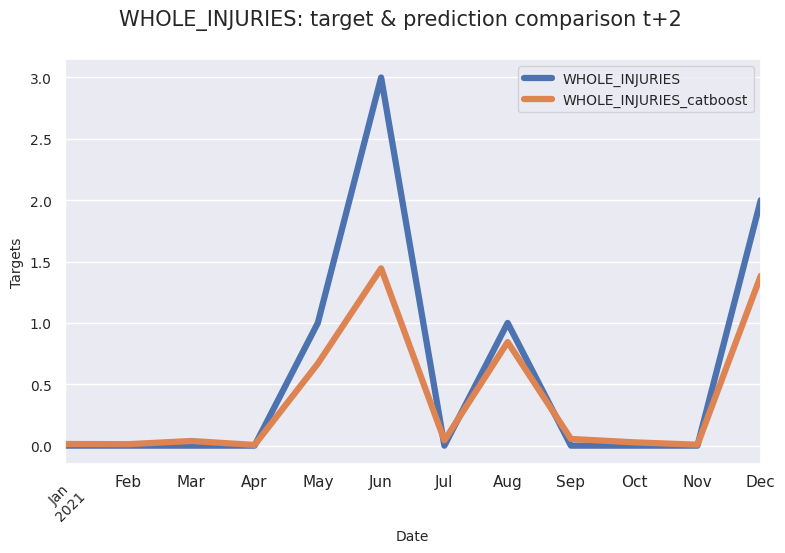

In [ ]:
# Plot results
test_df_catboost_t_2=test_2021.copy()
test_df_catboost_t_2 = pd.concat([test_df_catboost_t_2, predictions_te_catboost_t_2.set_index(test_df_catboost_t_2.index)], axis=1)
test_df_catboost_t_2_agg = test_df_catboost_t_2.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_catboost': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_catboost_t_2_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+2', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


### Prediction step 3

In [ ]:
# create lag and window features on all dataset for t+3
test_df_pred_catboost_t_2 = test_df_catboost_t_2.copy()
test_df_pred_catboost_t_2.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
test_df_pred_catboost_t_2.rename(columns={'WHOLE_INJURIES_catboost': 'WHOLE_INJURIES'}, inplace=True)

# create lag and window features on all dataset for t+3
all_t_3=pd.concat([train,test_df_pred_catboost_t_1,test_df_pred_catboost_t_2,test_2022],axis=0)
all_lag_t_3=lag_feat(all_t_3, 'WHOLE_INJURIES')
all_win_lag_t_3=win_feat(all_lag_t_3,'WHOLE_INJURIES')

# retrieve test set for t+3
test_t_3 = all_win_lag_t_3[(all_win_lag_t_3.index >= '2022-01-01') & (all_win_lag_t_3.index < '2023-01-01')]

# split features from target for t+3
X_test_t_3 = test_t_3.copy()
y_test_t_3 = X_test_t_3.WHOLE_INJURIES
y_test_t_3 = pd.DataFrame(y_test_t_3, columns=['WHOLE_INJURIES'])
X_test_t_3.drop(['WHOLE_INJURIES'], axis=1, inplace=True)
X_test_t_3['EXPOSURE'] = X_test_t_3.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure_t_3=X_test_t_3.EXPOSURE
X_test_t_3.drop(['EXPOSURE'], axis=1, inplace=True)


In [ ]:
score_catboost_t_3 = []
predictions_te_catboost_t_3 = catboost_fitted.predict(X_test_t_3)
rmse_test = np.sqrt(mean_squared_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_catboost_t_3))
mae_test = mean_absolute_error(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_catboost_t_3)
mpd_test = mean_poisson_deviance(y_test_t_3.squeeze()/test_exposure_t_3.values, predictions_te_catboost_t_3)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_catboost_t_3.append(score_dict)
score_catboost_t_3 = pd.DataFrame(score_catboost_t_3, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_te_catboost_t_3 = pd.DataFrame(predictions_te_catboost_t_3*test_exposure_t_3.values, columns = ['WHOLE_INJURIES_catboost'])



### Evaluation step 3

In [ ]:
catboost_results_t_3 = {'step':['t+3'],
                'model':['catboost'],
               'rmse_train':score_catboost_t_3['rmse_train'],
               'rmse_test': score_catboost_t_3['rmse_test'],
              'mae_train': score_catboost_t_3['mae_train'],
              'mae_test': score_catboost_t_3['mae_test'],
               'mpd_train': score_catboost_t_3['mpd_train'],
               'mpd_test': score_catboost_t_3['mpd_test']
               }
score_catboost_t_3 = pd.DataFrame(catboost_results_t_3,
                         columns=['step','model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_catboost_t_3


step     model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  \
0  t+3  catboost     0.00072    0.00025   0.000022  0.000009   0.000072   

   mpd_test  
0  0.000042

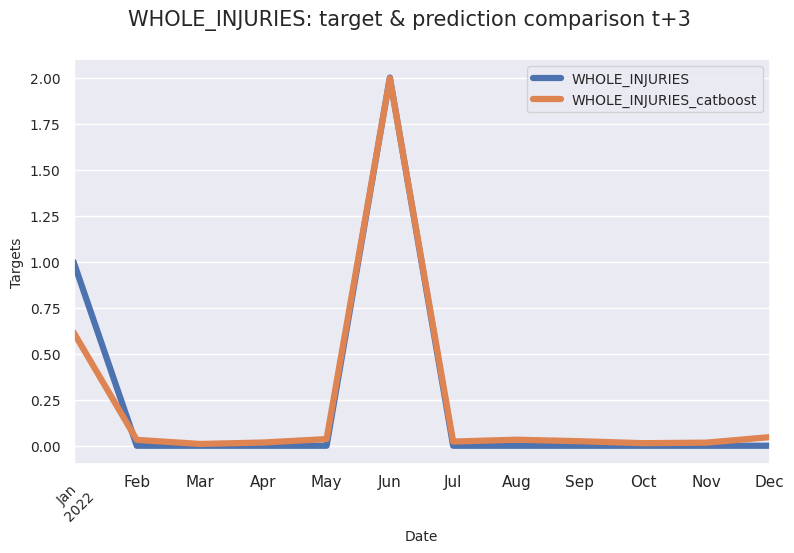

In [ ]:
# Plot results
test_df_catboost_t_3=test_2022.copy()
test_df_catboost_t_3 = pd.concat([test_df_catboost_t_3, predictions_te_catboost_t_3.set_index(test_df_catboost_t_3.index)], axis=1)
test_df_catboost_t_3_agg = test_df_catboost_t_3.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_catboost': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_catboost_t_3_agg.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES: target & prediction comparison t+3', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


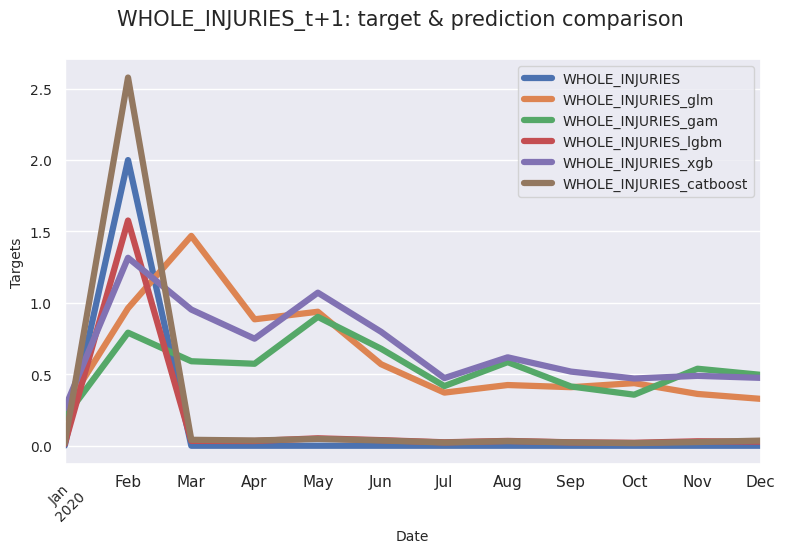

In [ ]:
# plot all models t+1
test_df_t_1 = pd.concat([test_t_1['WHOLE_INJURIES'],
                         predictions_te_glm_t_1.set_index(test_t_1.index),
                         predictions_te_gam_t_1.set_index(test_t_1.index),
                         predictions_te_lgbm_t_1.set_index(test_t_1.index),
                         predictions_te_xgb_t_1.set_index(test_t_1.index),
                         predictions_te_catboost_t_1.set_index(test_t_1.index)], axis=1)
test_df_agg_t_1 = test_df_t_1.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_glm': 'sum',
    'WHOLE_INJURIES_gam': 'sum',
    'WHOLE_INJURIES_lgbm': 'sum',
    'WHOLE_INJURIES_xgb': 'sum',
    'WHOLE_INJURIES_catboost': 'sum'
    })
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg_t_1.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES_t+1: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

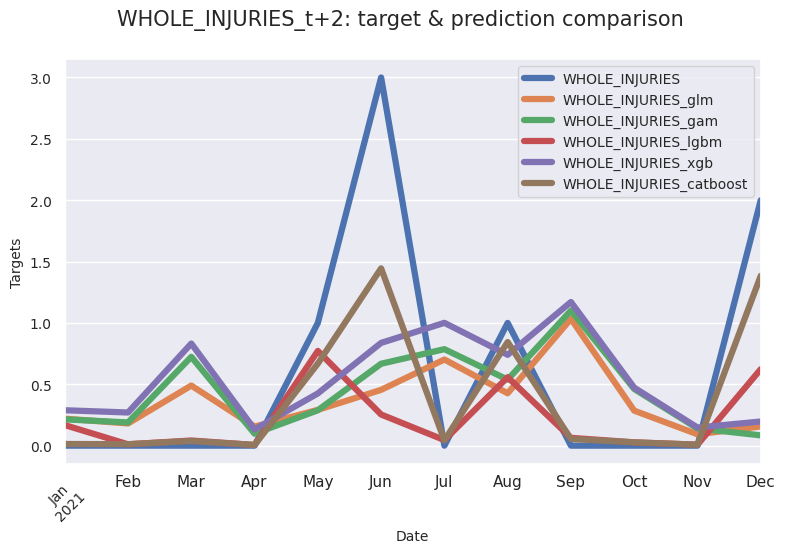

In [ ]:
# plot all models t+2
test_df_t_2 = pd.concat([test_t_2['WHOLE_INJURIES'],
                         predictions_te_glm_t_2.set_index(test_t_2.index),
                         predictions_te_gam_t_2.set_index(test_t_2.index),
                         predictions_te_lgbm_t_2.set_index(test_t_2.index),
                         predictions_te_xgb_t_2.set_index(test_t_2.index),
                         predictions_te_catboost_t_2.set_index(test_t_2.index)], axis=1)
test_df_agg_t_2 = test_df_t_2.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_glm': 'sum',
    'WHOLE_INJURIES_gam': 'sum',
    'WHOLE_INJURIES_lgbm': 'sum',
    'WHOLE_INJURIES_xgb': 'sum',
    'WHOLE_INJURIES_catboost': 'sum'
    })
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg_t_2.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES_t+2: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

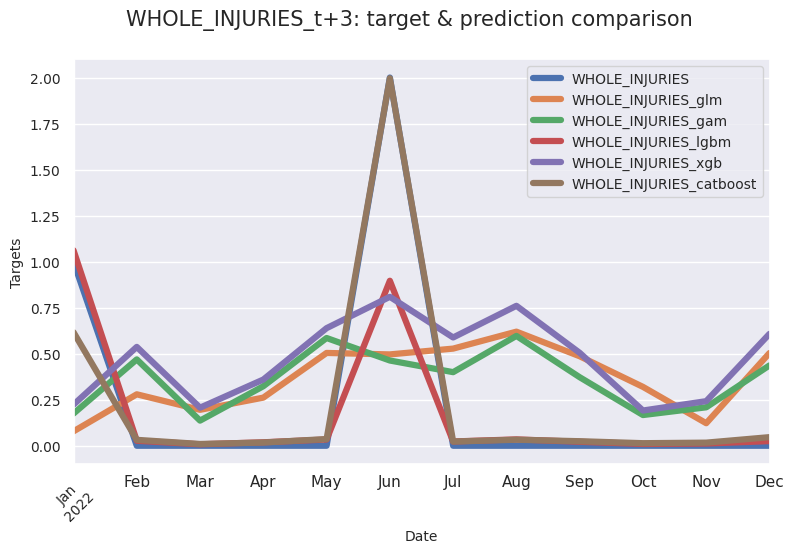

In [ ]:
# plot all models t+3
test_df_t_3 = pd.concat([test_t_3['WHOLE_INJURIES'],
                        predictions_te_glm_t_3.set_index(test_t_3.index),
                        predictions_te_gam_t_3.set_index(test_t_3.index),
                        predictions_te_lgbm_t_3.set_index(test_t_3.index),
                        predictions_te_xgb_t_3.set_index(test_t_3.index),
                        predictions_te_catboost_t_3.set_index(test_t_3.index)], axis=1)
test_df_agg_t_3 = test_df_t_3.groupby(pd.Grouper(freq='M')).agg({
    'WHOLE_INJURIES': 'sum',
    'WHOLE_INJURIES_glm': 'sum',
    'WHOLE_INJURIES_gam': 'sum',
    'WHOLE_INJURIES_lgbm': 'sum',
    'WHOLE_INJURIES_xgb': 'sum',
    'WHOLE_INJURIES_catboost': 'sum'
    })
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg_t_3.plot(linewidth=4.5)
plt.suptitle('WHOLE_INJURIES_t+3: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()


In [ ]:
def plot_metrics(score_df):
  # Reset the index of the DataFrame
  score_df = score_df.reset_index(drop=True)


  # Replace 'N/A' with 0 only for the 'naive' row
  score_df.loc[score_df['model'] == 'naive', ['mpd_train', 'mpd_test']] = score_df.loc[score_df['model'] == 'naive', ['mpd_train', 'mpd_test']].replace('N/A', 0)

  # Convert 'mpd_train' and 'mpd_test' to float type
  score_df['mpd_train'] = score_df['mpd_train'].astype(float)
  score_df['mpd_test'] = score_df['mpd_test'].astype(float)

  # Plotting 6 charts with 3 per row
  plt.figure(figsize=(18, 12))

  # Plot RMSE comparison for Train and Test
  plt.subplot(2, 3, 1)
  plt.bar(score_df['model'], score_df['rmse_train'], color='b', alpha=0.7, label='RMSE Train')
  plt.xlabel('Model',fontsize=15)
  plt.ylabel('RMSE')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('RMSE Comparison - Train')

  plt.subplot(2, 3, 4)
  plt.bar(score_df['model'], score_df['rmse_test'], color='r', alpha=0.7, label='RMSE Test')
  plt.xlabel('Model')
  plt.ylabel('RMSE')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('RMSE Comparison - Test')

  # Plot MAE comparison for Train and Test
  plt.subplot(2, 3, 2)
  plt.bar(score_df['model'], score_df['mae_train'], color='b', alpha=0.7, label='MAE Train')
  plt.xlabel('Model')
  plt.xticks(fontsize=15)
  plt.ylabel('MAE')
  plt.legend()
  plt.title('MAE Comparison - Train')

  plt.subplot(2, 3, 5)
  plt.bar(score_df['model'], score_df['mae_test'], color='r', alpha=0.7, label='MAE Test')
  plt.xlabel('Model')
  plt.ylabel('MAE')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('MAE Comparison - Test')

  # Plot MPD comparison for Train and Test
  plt.subplot(2, 3, 3)
  plt.bar(score_df['model'], score_df['mpd_train'], color='b', alpha=0.7, label='MPD Train')
  plt.xlabel('Model')
  plt.ylabel('MPD')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('MPD Comparison - Train')

  plt.subplot(2, 3, 6)
  plt.bar(score_df['model'], score_df['mpd_test'], color='r', alpha=0.7, label='MPD Test')
  plt.xlabel('Model')
  plt.ylabel('MPD')
  plt.xticks(fontsize=15)
  plt.legend()
  plt.title('MPD Comparison - Test')

  plt.tight_layout()
  plt.show()

In [ ]:
# total score
score_t_1 = pd.concat([score_glm_t_1, score_gam_t_1,score_lgbm_t_1,
                       score_xgb_t_1, score_catboost_t_1])
score_t_1

step     model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  \
0  t+1       glm    0.000800   0.000026   0.000025  0.000007   0.000260   
0  t+1       gam    0.000801   0.000026   0.000023  0.000005   0.000292   
0  t+1      lgbm    0.000405   0.000027   0.000012  0.000002   0.000022   
0  t+1       xgb    0.000799   0.000026   0.000026  0.000007   0.000193   
0  t+1  catboost    0.000720   0.000026   0.000022  0.000002   0.000072   

   mpd_test  
0  0.000017  
0  0.000015  
0  0.000004  
0  0.000016  
0  0.000004

In [ ]:
# total score
score_t_2 = pd.concat([score_glm_t_2, score_gam_t_2, score_lgbm_t_2,
                       score_xgb_t_2, score_catboost_t_2])
score_t_2

step     model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  \
0  t+2       glm    0.000800   0.000629   0.000025  0.000026   0.000260   
0  t+2       gam    0.000801   0.000629   0.000023  0.000024   0.000292   
0  t+2      lgbm    0.000405   0.000606   0.000012  0.000023   0.000022   
0  t+2       xgb    0.000799   0.000628   0.000026  0.000026   0.000193   
0  t+2  catboost    0.000720   0.000602   0.000022  0.000026   0.000072   

   mpd_test  
0  0.000293  
0  0.000302  
0  0.000095  
0  0.000227  
0  0.000094

In [ ]:
# total score
score_t_3 = pd.concat([score_glm_t_3, score_gam_t_3, score_lgbm_t_3,
                       score_xgb_t_3, score_catboost_t_3])
score_t_3

step     model  rmse_train  rmse_test  mae_train  mae_test  mpd_train  \
0  t+3       glm    0.000800   0.000255   0.000025  0.000013   0.000260   
0  t+3       gam    0.000801   0.000254   0.000023  0.000011   0.000292   
0  t+3      lgbm    0.000405   0.000267   0.000012  0.000012   0.000022   
0  t+3       xgb    0.000799   0.000254   0.000026  0.000013   0.000193   
0  t+3  catboost    0.000720   0.000250   0.000022  0.000009   0.000072   

   mpd_test  
0  0.000098  
0  0.000099  
0  0.000038  
0  0.000081  
0  0.000042

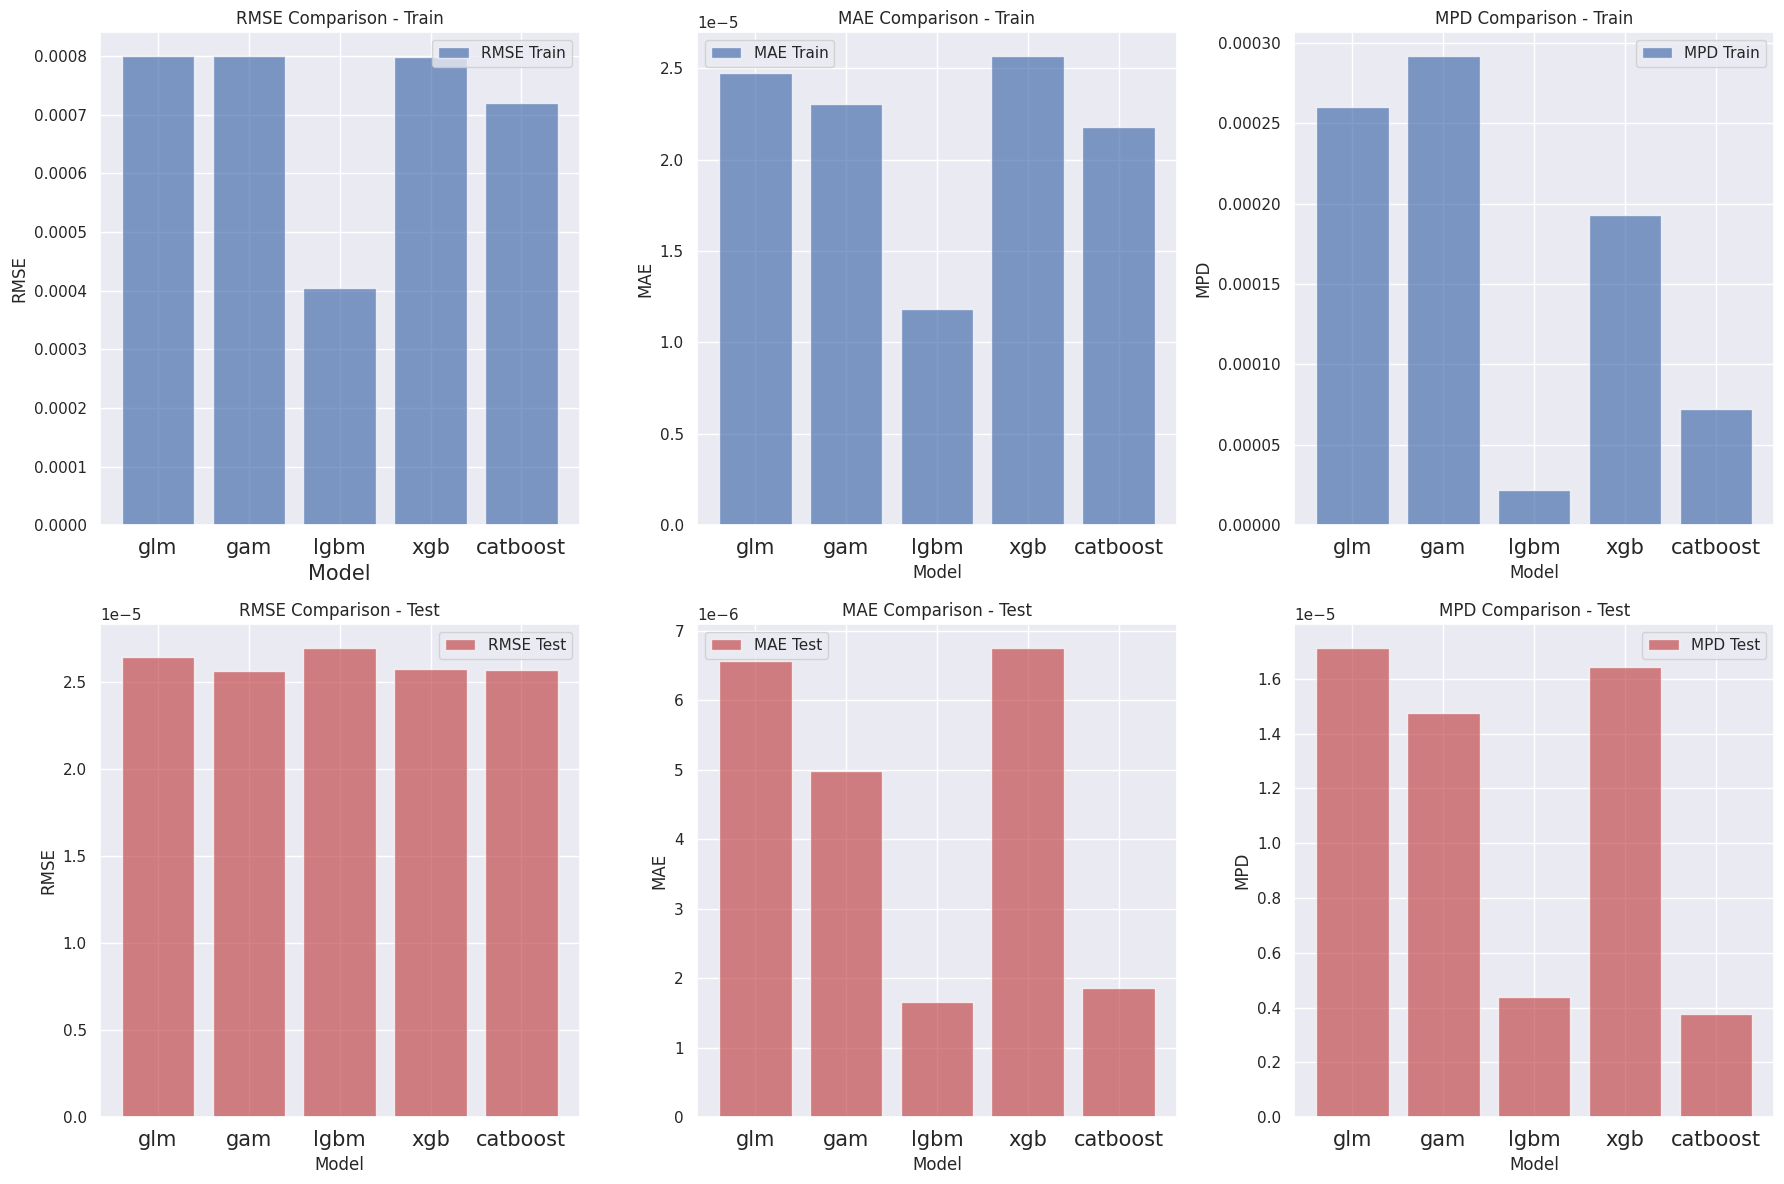

In [ ]:
plot_metrics(score_t_1)

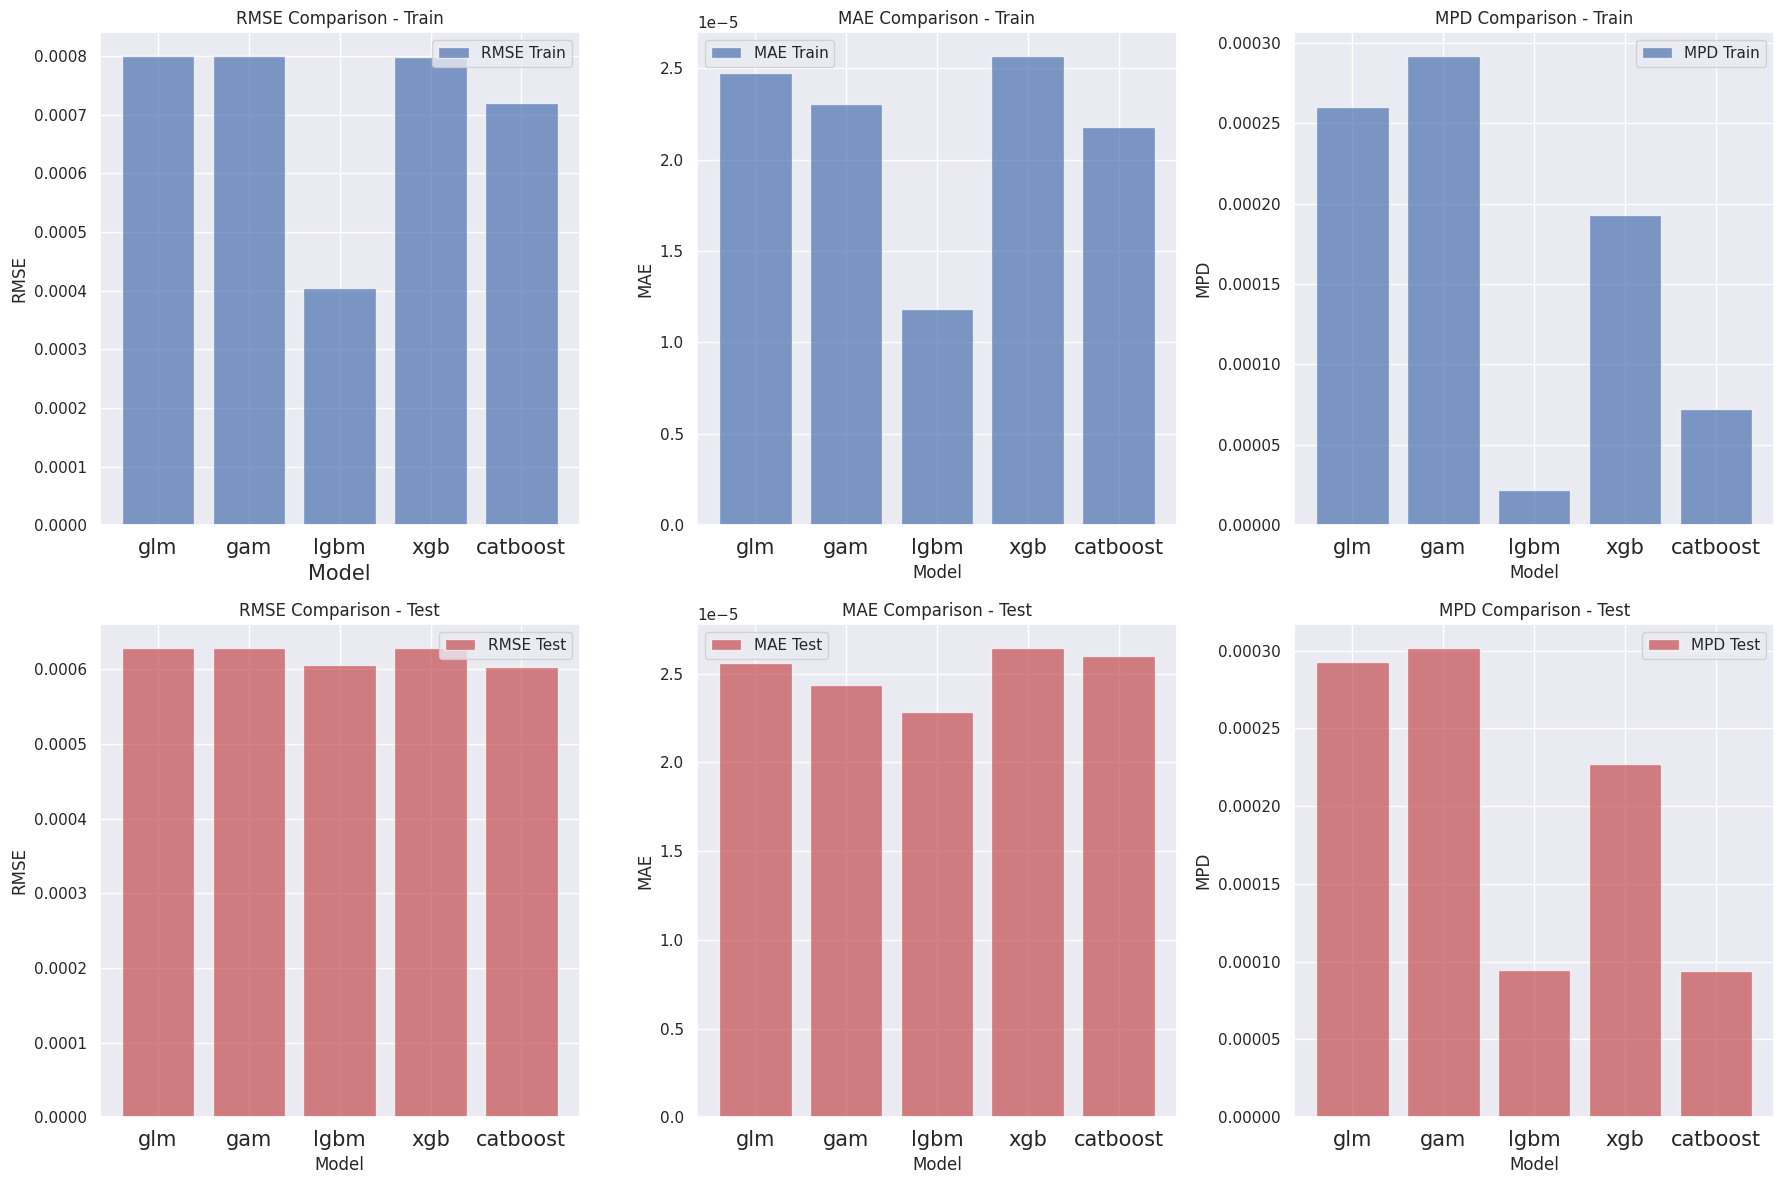

In [ ]:
plot_metrics(score_t_2)

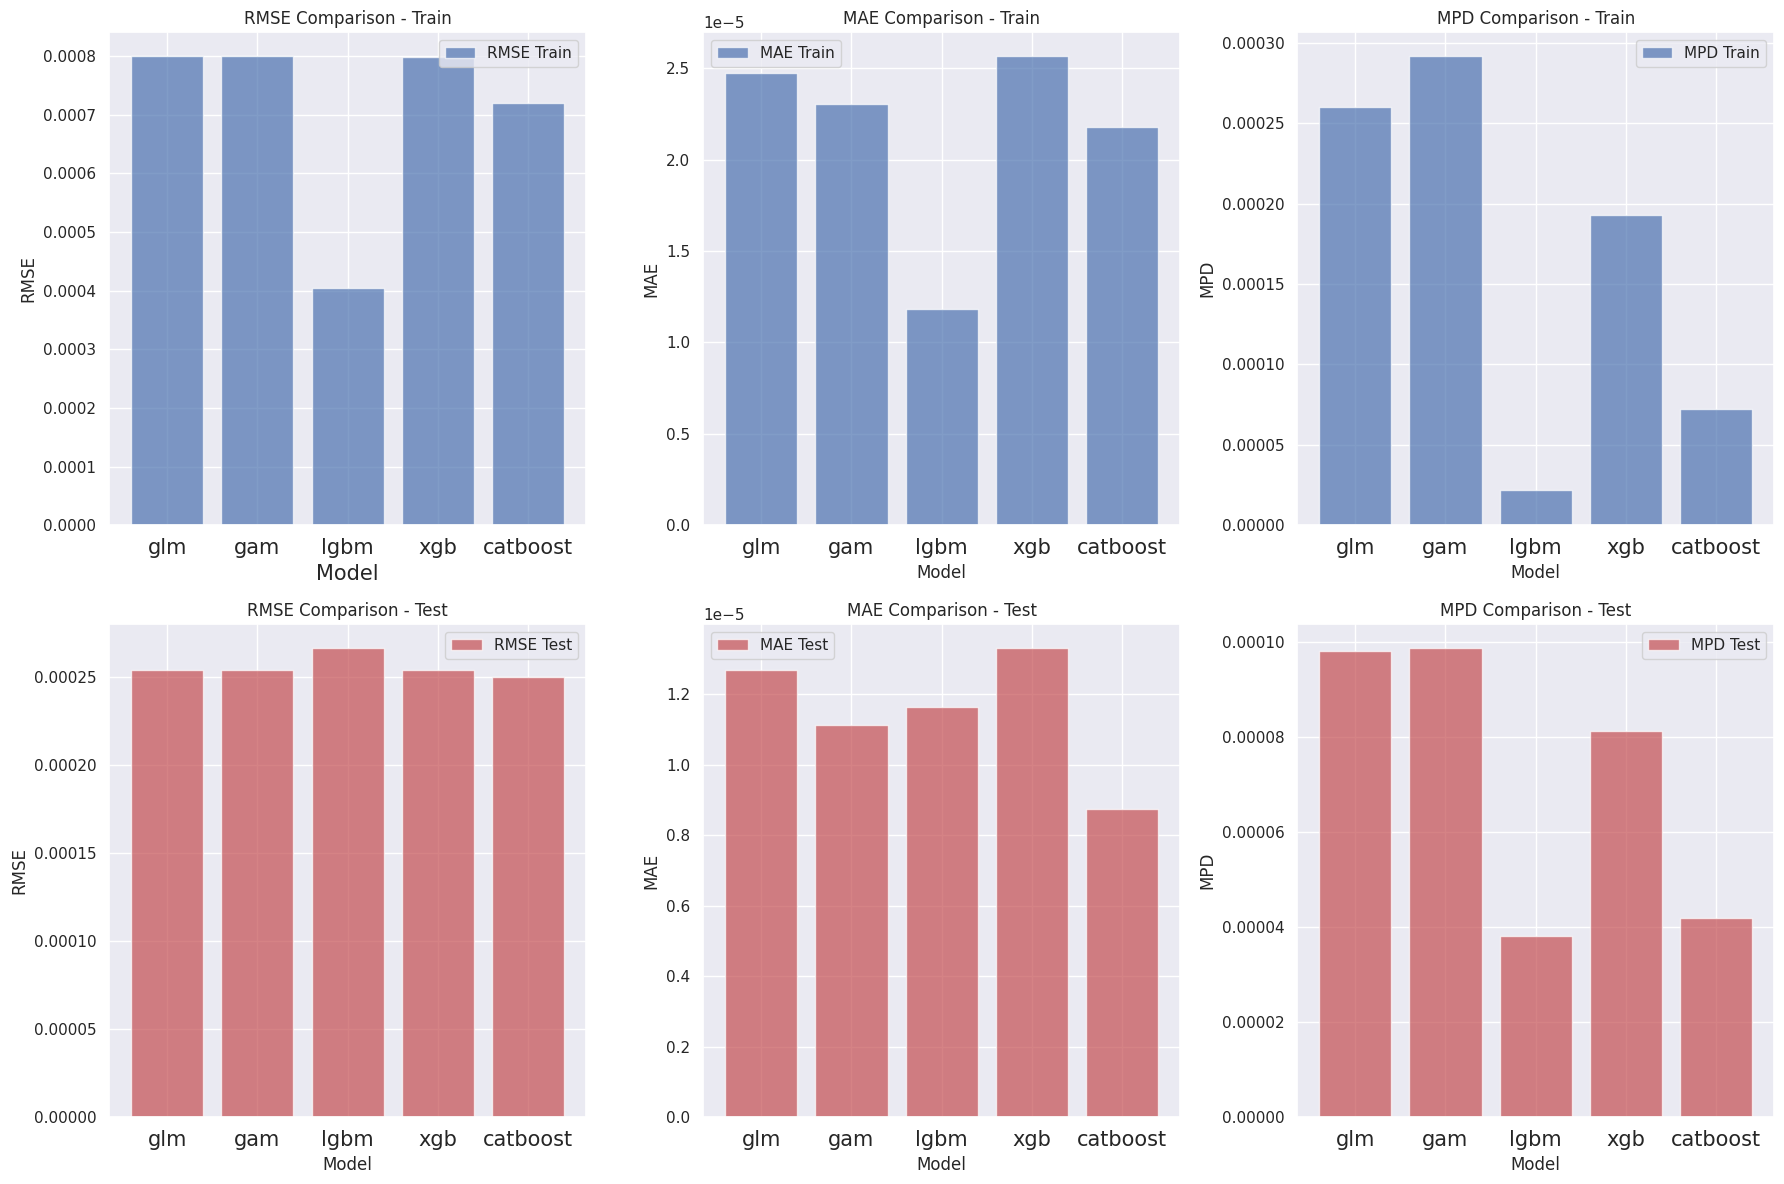

In [ ]:
plot_metrics(score_t_3)